In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d

In [2]:
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude,  PVAangleToRoi, PVA_radian_to_angle,calculateBumpWidth_v1
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import offset_calculation, moving_wrapped_plot_by_offset

In [3]:
#Read the imaging/behavior data after preprocessing
pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/test/shi/TQfly125-001-imaging-normalized.csv')
pd_imaging_behavior_preprocessed

Time_Stamp   F_Roi_1   F_Roi_2    F_Roi_3    F_Roi_4    F_Roi_5   
0        0.00000  8.001780  8.183639   9.859755   6.256698  11.558664  \
1        0.11081  3.318798  7.427532  11.453620  10.463998   7.660199   
2        0.22162  4.990951  6.188445   8.770110  13.177593  12.952367   
3        0.33243  5.405892  5.066021   9.872598  12.207659  11.118487   
4        0.44324  2.190461  6.298453   8.476612  11.977827  13.331223   
...          ...       ...       ...        ...        ...        ...   
2703   299.51943  2.840491  3.672640   9.874504   7.833566   8.015113   
2704   299.63024  4.683263  6.567732  10.224996   7.153757   8.442503   
2705   299.74105  5.986976  8.653854   8.303094   7.492342   7.920946   
2706   299.85186  8.902033  5.148377   8.793795   7.264522   7.174988   
2707   299.96267  5.610356  5.711244  10.833454   8.701340   7.336722   

        F_Roi_6    F_Roi_7   F_Roi_8    Raw_F_1  ...  PVA_Radian_offset   
0      9.935002   8.195257  5.311312   5.824766  ...          -2.741756  \
1     10.337602  11.513794  7.829117   2.190421  ...           2.994835   
2     11.951449  10.532407  5.538048   5.808022  ...           2.743829   
3     10.637969  10.375976  3.595553   5.723520  ...           2.853577   
4     10.808792   9.436868  3.289836   3.132009  ...           2.946341   
...         ...        ...       ...        ...  ...                ...   
2703  12.686125  18.846521  9.975570   0.839174  ...          -0.946396   
2704  10.440143  13.486828  6.478481   5.163162  ...          -1.027351   
2705  11.768551  18.661701  8.744071   1.149533  ...          -1.198731   
2706  10.791201  20.723915  6.793404  10.227804  ...          -1.320218   
2707  14.331321  17.949446  4.719535   2.095405  ...          -1.276843   

       PVA_Angle  Angular_Velocity  Bar_Position/Heading   
0    -157.091060          0.044275              2.451789  \
1     171.591403         -0.008115              2.456695   
2     157.209816          0.504926              2.449991   
3     163.497945          2.824749              2.568597   
4     168.812903          2.882529              3.076012   
...          ...               ...                   ...   
2703  -54.224508          0.332036             -0.563447   
2704  -58.862848          0.329802             -0.450971   
2705  -68.682228         -0.195324             -0.490356   
2706  -75.642917         -0.012517             -0.494258   
2707  -73.157705          0.010180             -0.493130   

      Unwrapped_Bar_Position/Heading  Unwrapped_Radian  Integrated_x   
0                           2.451789         -2.741756     -1.452053  \
1                           2.456695         -3.288350     -1.469794   
2                           2.449991         -3.539356     -1.481647   
3                           2.568597         -3.429608     -1.479203   
4                           3.076012         -3.336844     -1.412210   
...                              ...               ...           ...   
2703                       55.985221         17.903160     -1.830505   
2704                       56.097697         17.822205     -1.831782   
2705                       56.058312         17.650825     -1.849247   
2706                       56.054410         17.529338     -1.814143   
2707                       56.055538         17.572713     -1.769547   

      Integrated_y  PVA_strength  Bump_amplitude  
0         2.481958      0.302465        0.339591  
1         2.487206      0.884386        0.503224  
2         2.458003      0.722737        0.511607  
3         2.458777      0.832243        0.565923  
4         2.435646      0.940949        0.584354  
...            ...           ...             ...  
2703      2.995306      1.022519        0.878068  
2704      3.004297      0.989701        0.888057  
2705      3.014958      0.993311        0.813491  
2706      2.988467      0.916040        0.828658  
2707      2.977311      0.724760        0.508390  

[2708 rows x 44 columns]

In [4]:
trial_type = 0

In [5]:
volume_cycle = len(pd_imaging_behavior_preprocessed)
volume_time = pd_imaging_behavior_preprocessed['Time_Stamp'][1]
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [6]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian']
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle']
PVA_Radian = pd_imaging_behavior_preprocessed['PVA_Radian']
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity']
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x']
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength']
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude']
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading']
Wrapped_heading =pd_imaging_behavior_preprocessed['Bar_Position/Heading']

In [7]:
PVA_Unwrapped_Radian_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_Angle_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Angular_velocity_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
integrated_x_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
PVA_strength_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Bump_amplitude_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
Unwrapped_heading_no_series = np.zeros(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian']))
for i in range(len(pd_imaging_behavior_preprocessed['Unwrapped_Radian'])):
    PVA_Unwrapped_Radian_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Radian'][i]
    PVA_Angle[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    PVA_Angle_no_series[i] = pd_imaging_behavior_preprocessed['PVA_Angle'][i]
    Angular_velocity_no_series[i] = pd_imaging_behavior_preprocessed['Angular_Velocity'][i]
    integrated_x_no_series[i] = pd_imaging_behavior_preprocessed['Integrated_x'][i]
    PVA_strength_no_series[i] = pd_imaging_behavior_preprocessed['PVA_strength'][i]
    Bump_amplitude_no_series[i] = pd_imaging_behavior_preprocessed['Bump_amplitude'][i]
    Unwrapped_heading_no_series[i] = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'][i]


In [8]:
F_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['F_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    F_8_roi[i,0]= pd_imaging_behavior_preprocessed['F_Roi_1'][i]
    F_8_roi[i,1]= pd_imaging_behavior_preprocessed['F_Roi_2'][i]
    F_8_roi[i,2]= pd_imaging_behavior_preprocessed['F_Roi_3'][i]
    F_8_roi[i,3]= pd_imaging_behavior_preprocessed['F_Roi_4'][i]
    F_8_roi[i,4]= pd_imaging_behavior_preprocessed['F_Roi_5'][i]
    F_8_roi[i,5]= pd_imaging_behavior_preprocessed['F_Roi_6'][i]
    F_8_roi[i,6]= pd_imaging_behavior_preprocessed['F_Roi_7'][i]
    F_8_roi[i,7]= pd_imaging_behavior_preprocessed['F_Roi_8'][i]
bump_amplitude_F = calcualteBumpAmplitude(F_8_roi)

In [9]:
dff_normalized_8_roi = np.zeros((len(pd_imaging_behavior_preprocessed['dFF_Roi_1']), 8))
for i in range(len(pd_imaging_behavior_preprocessed['F_Roi_1'])):
    dff_normalized_8_roi[i,0]= pd_imaging_behavior_preprocessed['dFF_Roi_1'][i]
    dff_normalized_8_roi[i,1]= pd_imaging_behavior_preprocessed['dFF_Roi_2'][i]
    dff_normalized_8_roi[i,2]= pd_imaging_behavior_preprocessed['dFF_Roi_3'][i]
    dff_normalized_8_roi[i,3]= pd_imaging_behavior_preprocessed['dFF_Roi_4'][i]
    dff_normalized_8_roi[i,4]= pd_imaging_behavior_preprocessed['dFF_Roi_5'][i]
    dff_normalized_8_roi[i,5]= pd_imaging_behavior_preprocessed['dFF_Roi_6'][i]
    dff_normalized_8_roi[i,6]= pd_imaging_behavior_preprocessed['dFF_Roi_7'][i]
    dff_normalized_8_roi[i,7]= pd_imaging_behavior_preprocessed['dFF_Roi_8'][i]

In [10]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi

In [11]:
#plt.hist(Angular_velocity_no_series*180/np.pi, bins ='auto')
#plt.title('Angular_velocity distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [12]:
angular_speed_degrees = np.abs(Angular_velocity_no_series*180/np.pi)
#plt.hist(angular_speed_degrees, bins ='auto')
#plt.title('Angular_speed distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [13]:
#plt.hist(Forward_velocity *180/np.pi ,bins='auto')
#plt.title('Forward_velocity distribution', fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

In [14]:
#plt.hist(Forward_speed_degrees ,bins='auto')
#plt.title('Forward_speed distribution',fontsize = 30)
#plt.xlabel('Degrees',fontsize = 25)
#plt.ylabel('Counts',fontsize = 25)
#plt.show()

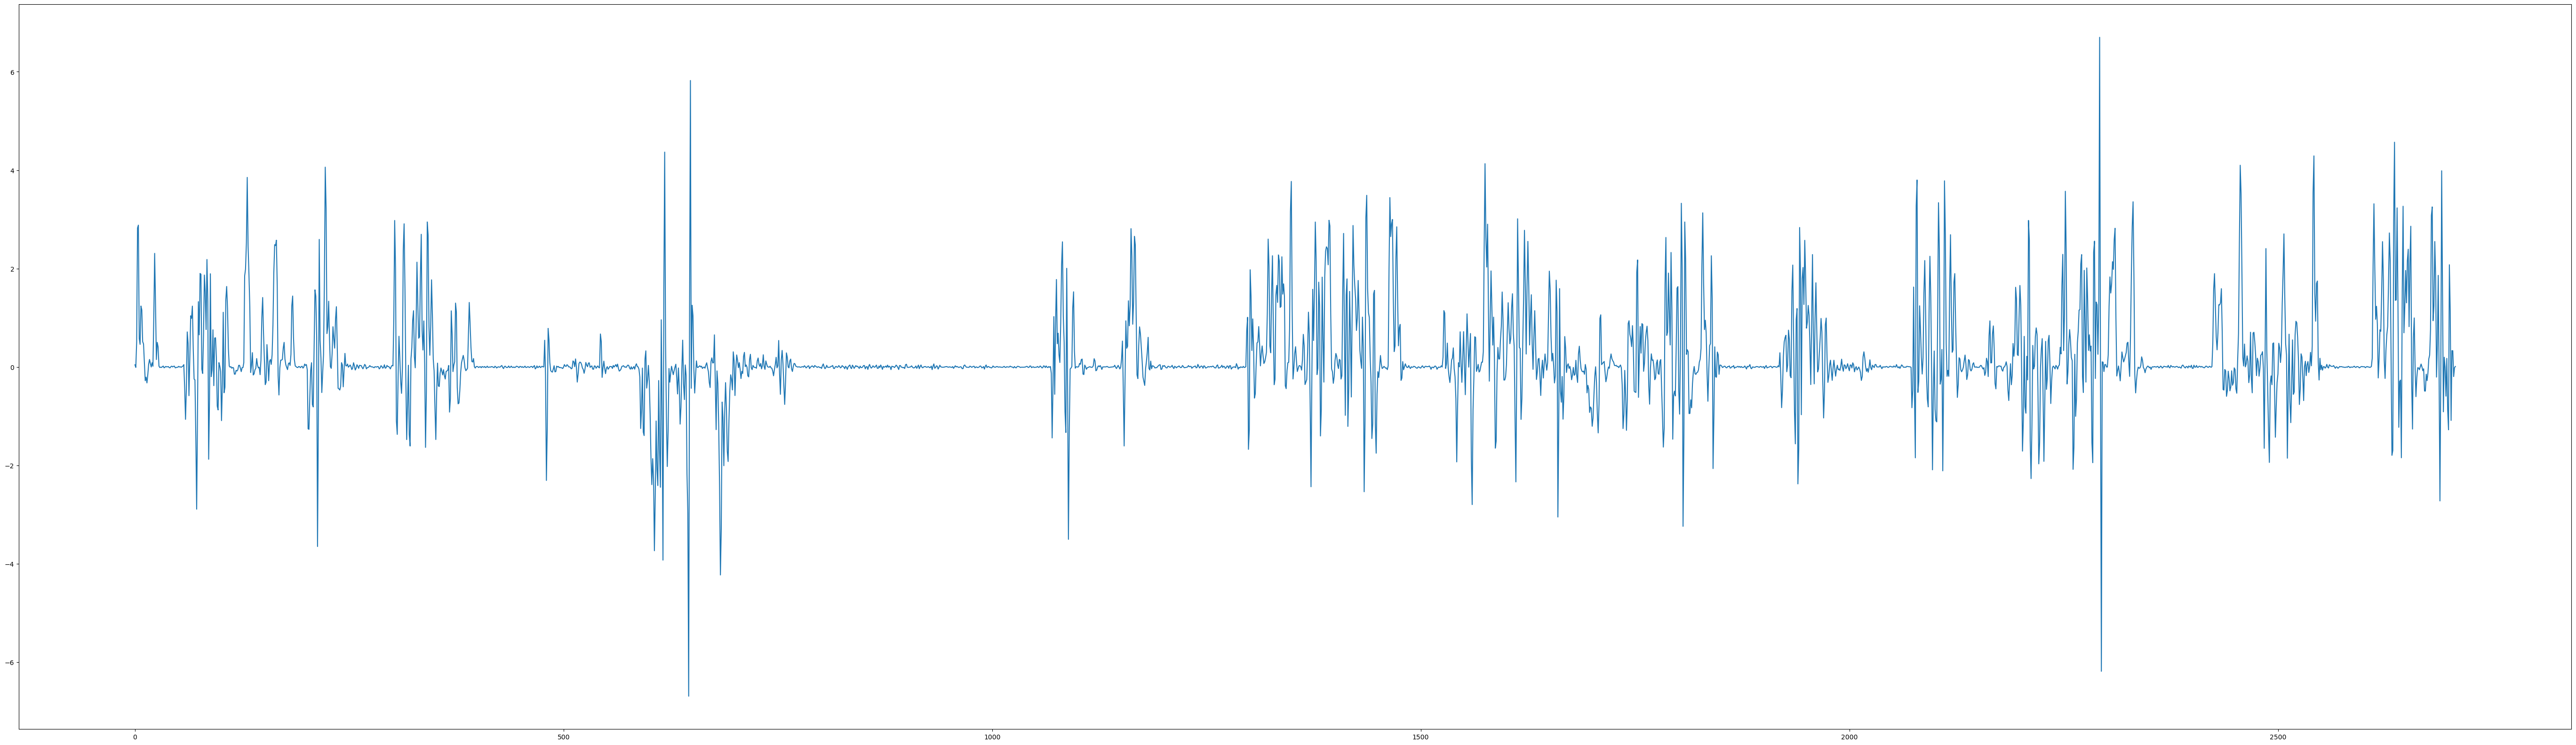

In [15]:
plt.figure(figsize= (70,20))
plt.plot(Angular_velocity)

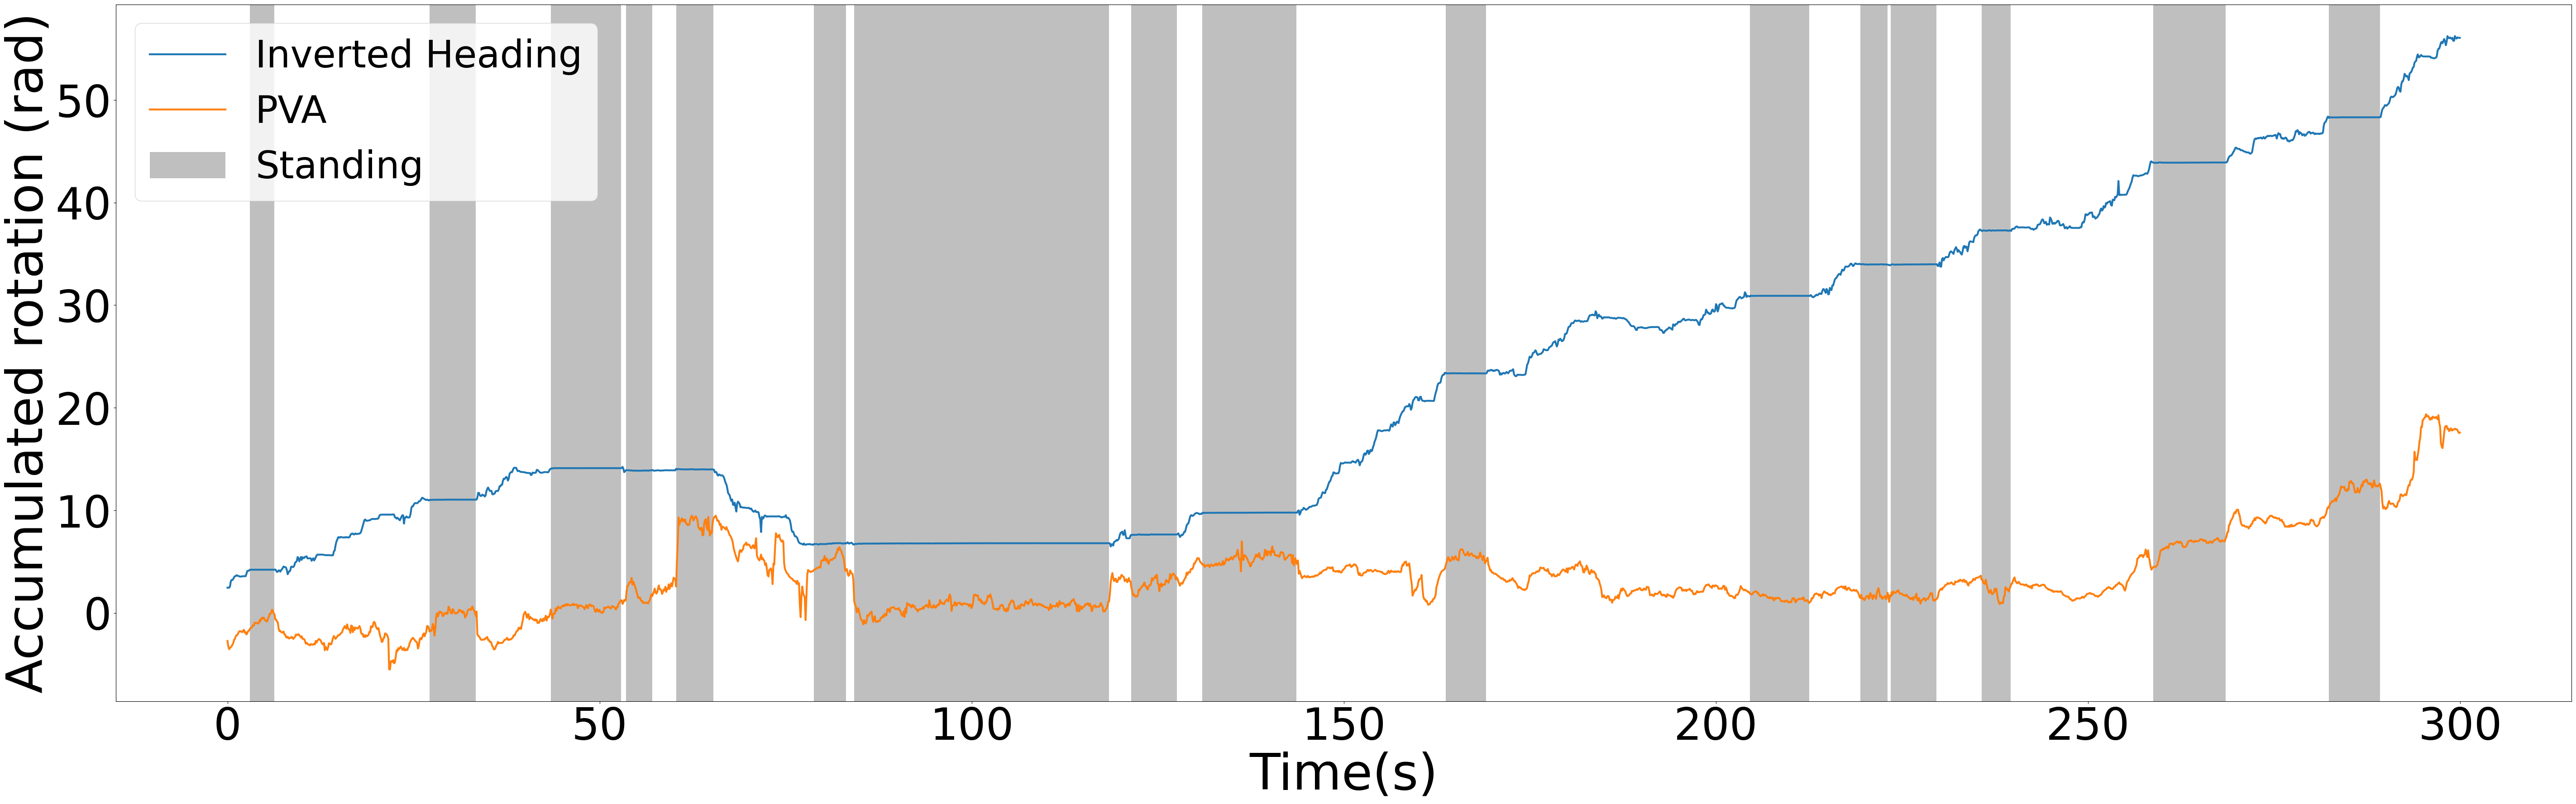

In [16]:
#find stop period and plot as shaded under unwrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.grid()
plt.show()

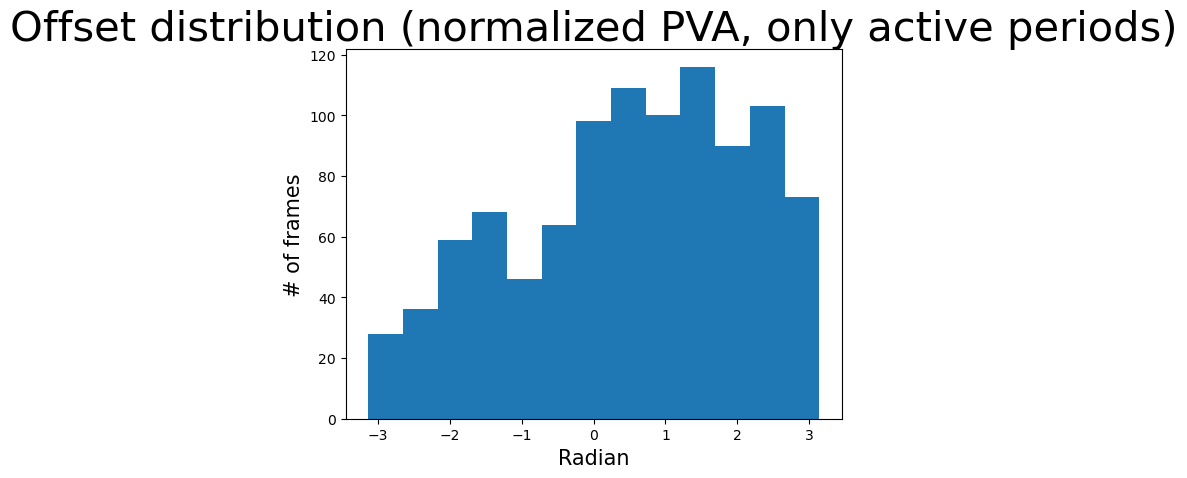

In [17]:
radian_offset_normalized = offset_calculation(Wrapped_heading, PVA_Radian, IfRadian = True)
# Bump offset excluding low velocity point
radian_offset_no_stopping_period_normalized = []
for i in range(len(Angular_velocity_no_series)):
    if np.abs(Angular_velocity_no_series[i]) >= 0.26:
        radian_offset_no_stopping_period_normalized.append(radian_offset_normalized[i])
plt.hist(radian_offset_no_stopping_period_normalized,bins='auto')
plt.title('Offset distribution (normalized PVA, only active periods)',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

In [18]:
PVA_radian_array_normalized_offset = moving_wrapped_plot_by_offset(PVA_Radian,math.degrees(1.5), ifRadian =True)

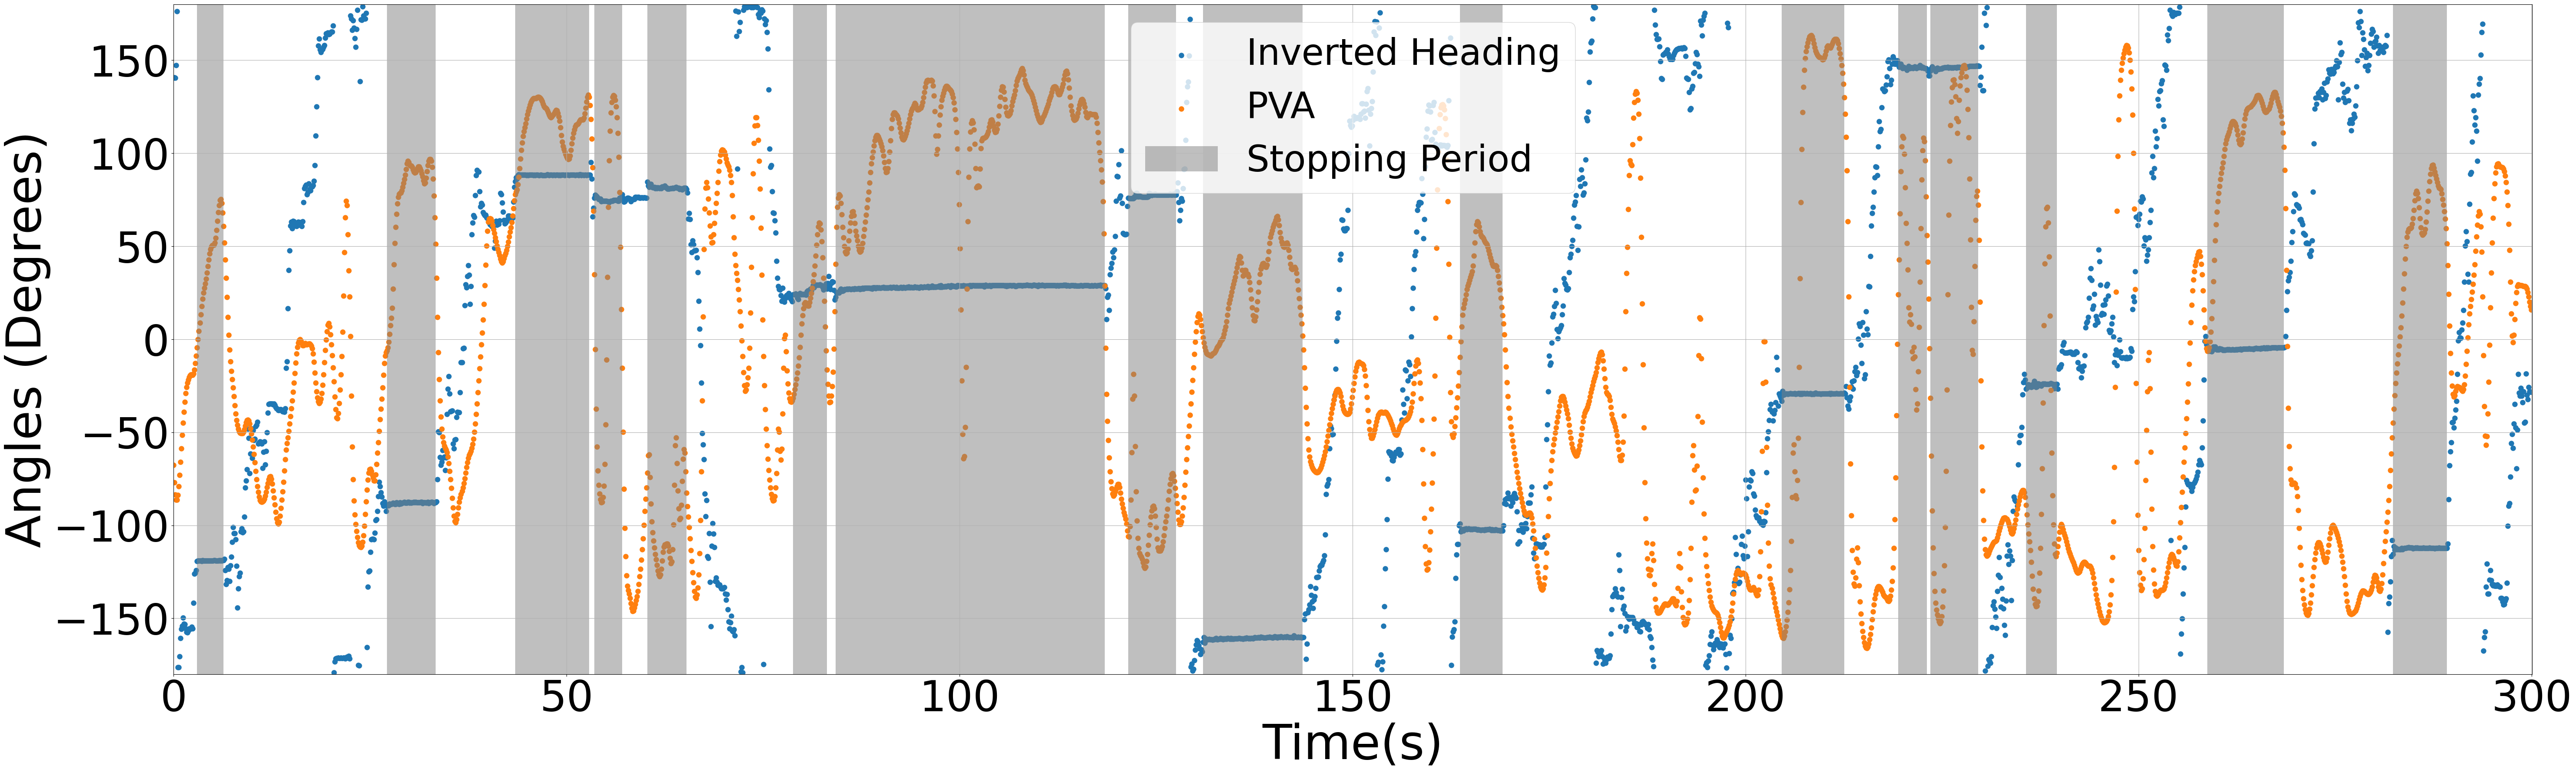

In [19]:
#Plot the stoping period as shaded under wrapped behavior
b = plt.figure(figsize= (70,20))
PVA_radian_array_normalized_offset_filtered = low_pass_filter_TQ(PVA_radian_array_normalized_offset,0.5,volume_rate)
PVA_radian_array_normalized_offset_filtered_angle = PVA_radian_to_angle(PVA_radian_array_normalized_offset_filtered)
Wrapped_heading_angle = PVA_radian_to_angle(Wrapped_heading )

plt.scatter(time_array_imaging,Wrapped_heading_angle ,linewidth =3)
plt.scatter(time_array_imaging,PVA_radian_array_normalized_offset_filtered_angle, linewidth = 3)
plt.xlabel('Time(s)', fontsize=80)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Angles (Degrees)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Stopping Period'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Stopping Period'],fontsize=60, loc = 4)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylim(-180, 180)
plt.grid()
plt.show()
#b.savefig('Behavior_trace_with_PVA', format ='svg')

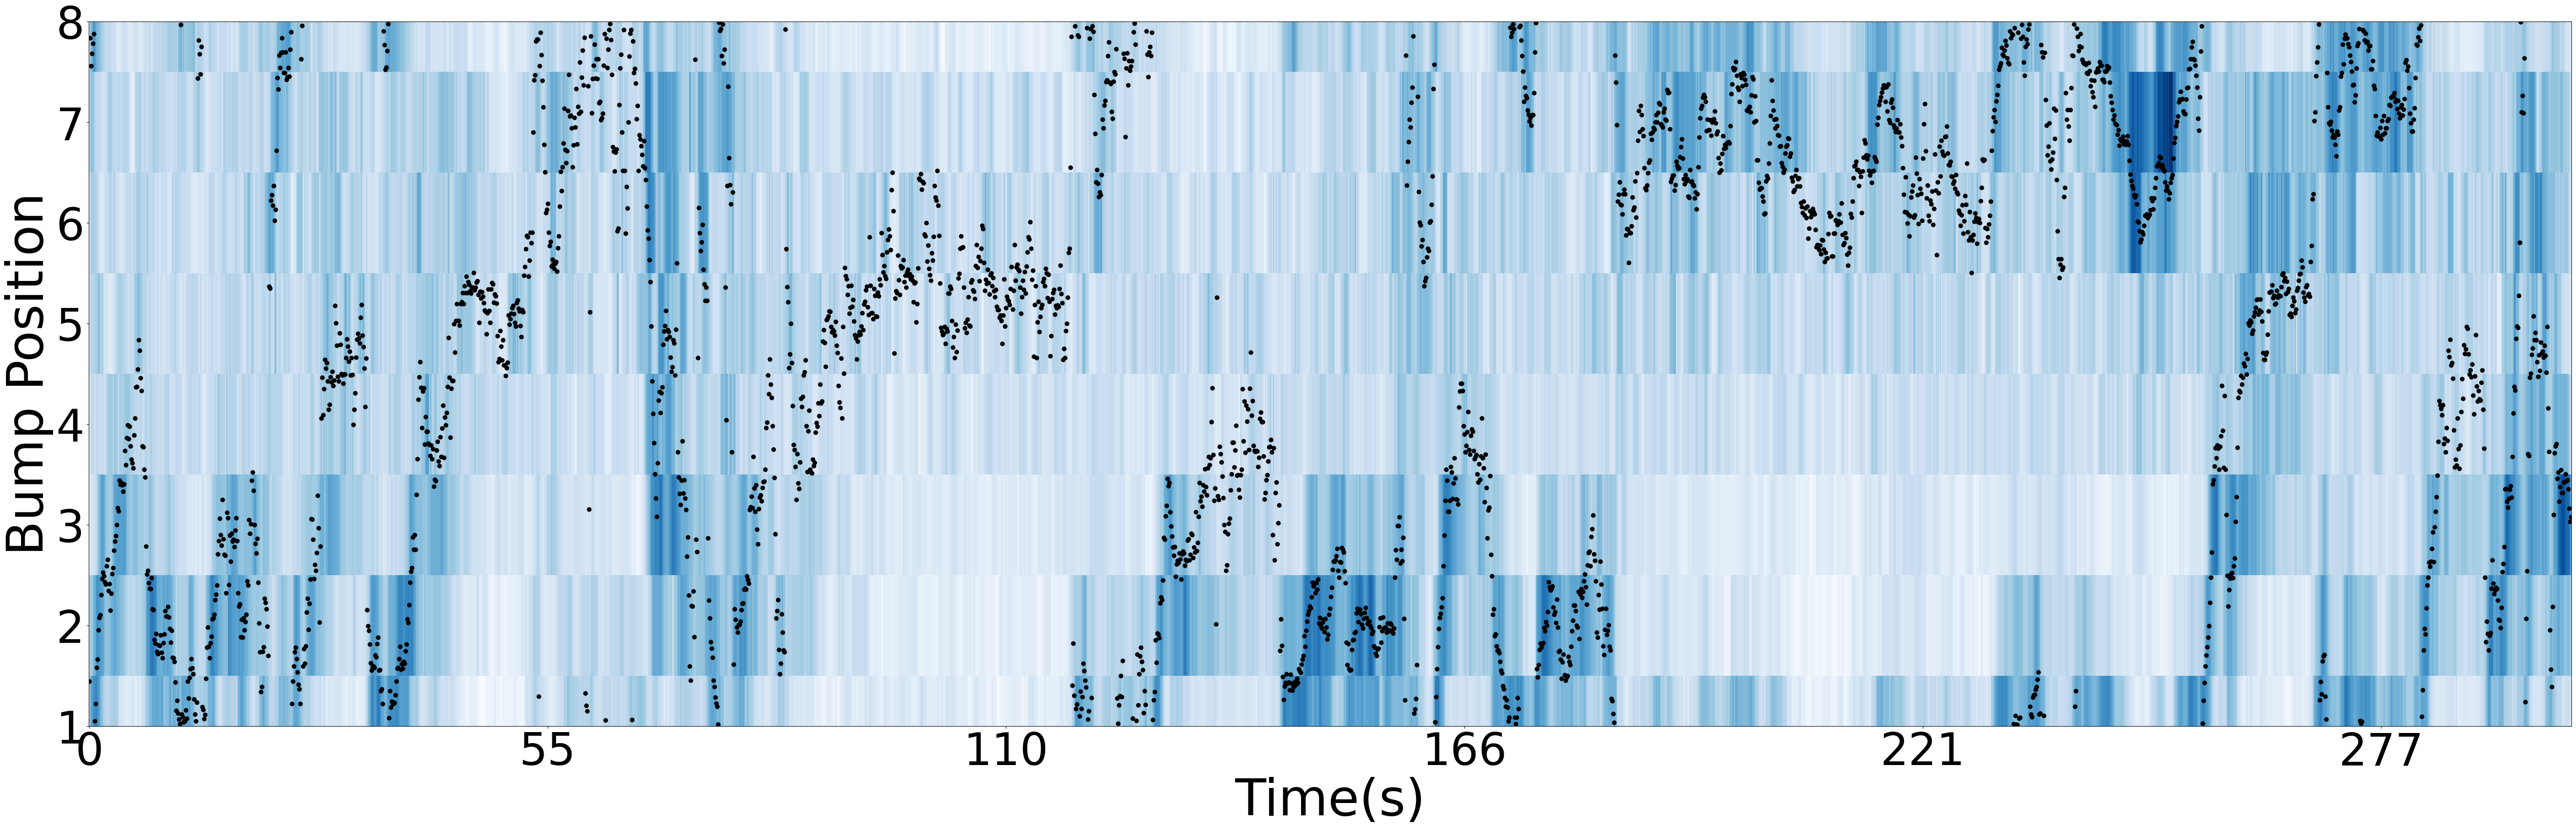

In [20]:
df_dff_in_ROI_normalized = dff_normalized_8_roi.transpose()
df_dff_in_ROI_normalized_shifted = np.zeros((np.size(df_dff_in_ROI_normalized,0),np.size(df_dff_in_ROI_normalized,1)))
df_dff_in_ROI_normalized_shifted[0,:] = df_dff_in_ROI_normalized[4,:]
df_dff_in_ROI_normalized_shifted[1,:] = df_dff_in_ROI_normalized[5,:]
df_dff_in_ROI_normalized_shifted[2,:] = df_dff_in_ROI_normalized[6,:]
df_dff_in_ROI_normalized_shifted[3,:] = df_dff_in_ROI_normalized[7,:] 
df_dff_in_ROI_normalized_shifted[4,:] = df_dff_in_ROI_normalized[0,:] 
df_dff_in_ROI_normalized_shifted[5,:] = df_dff_in_ROI_normalized[1,:] 
df_dff_in_ROI_normalized_shifted[6,:] = df_dff_in_ROI_normalized[2,:] 
df_dff_in_ROI_normalized_shifted[7,:] = df_dff_in_ROI_normalized[3,:] 
a=plt.figure(figsize= (70,20))
plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'Blues')
#plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', cmap = 'Blues')
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(PVA_Angle)),7*(PVA_Angle+180)/2/180, color ='black', s = 40)
plt.show()
#a.savefig('E-PG_Bump_Heatmap__dark', format ='svg')

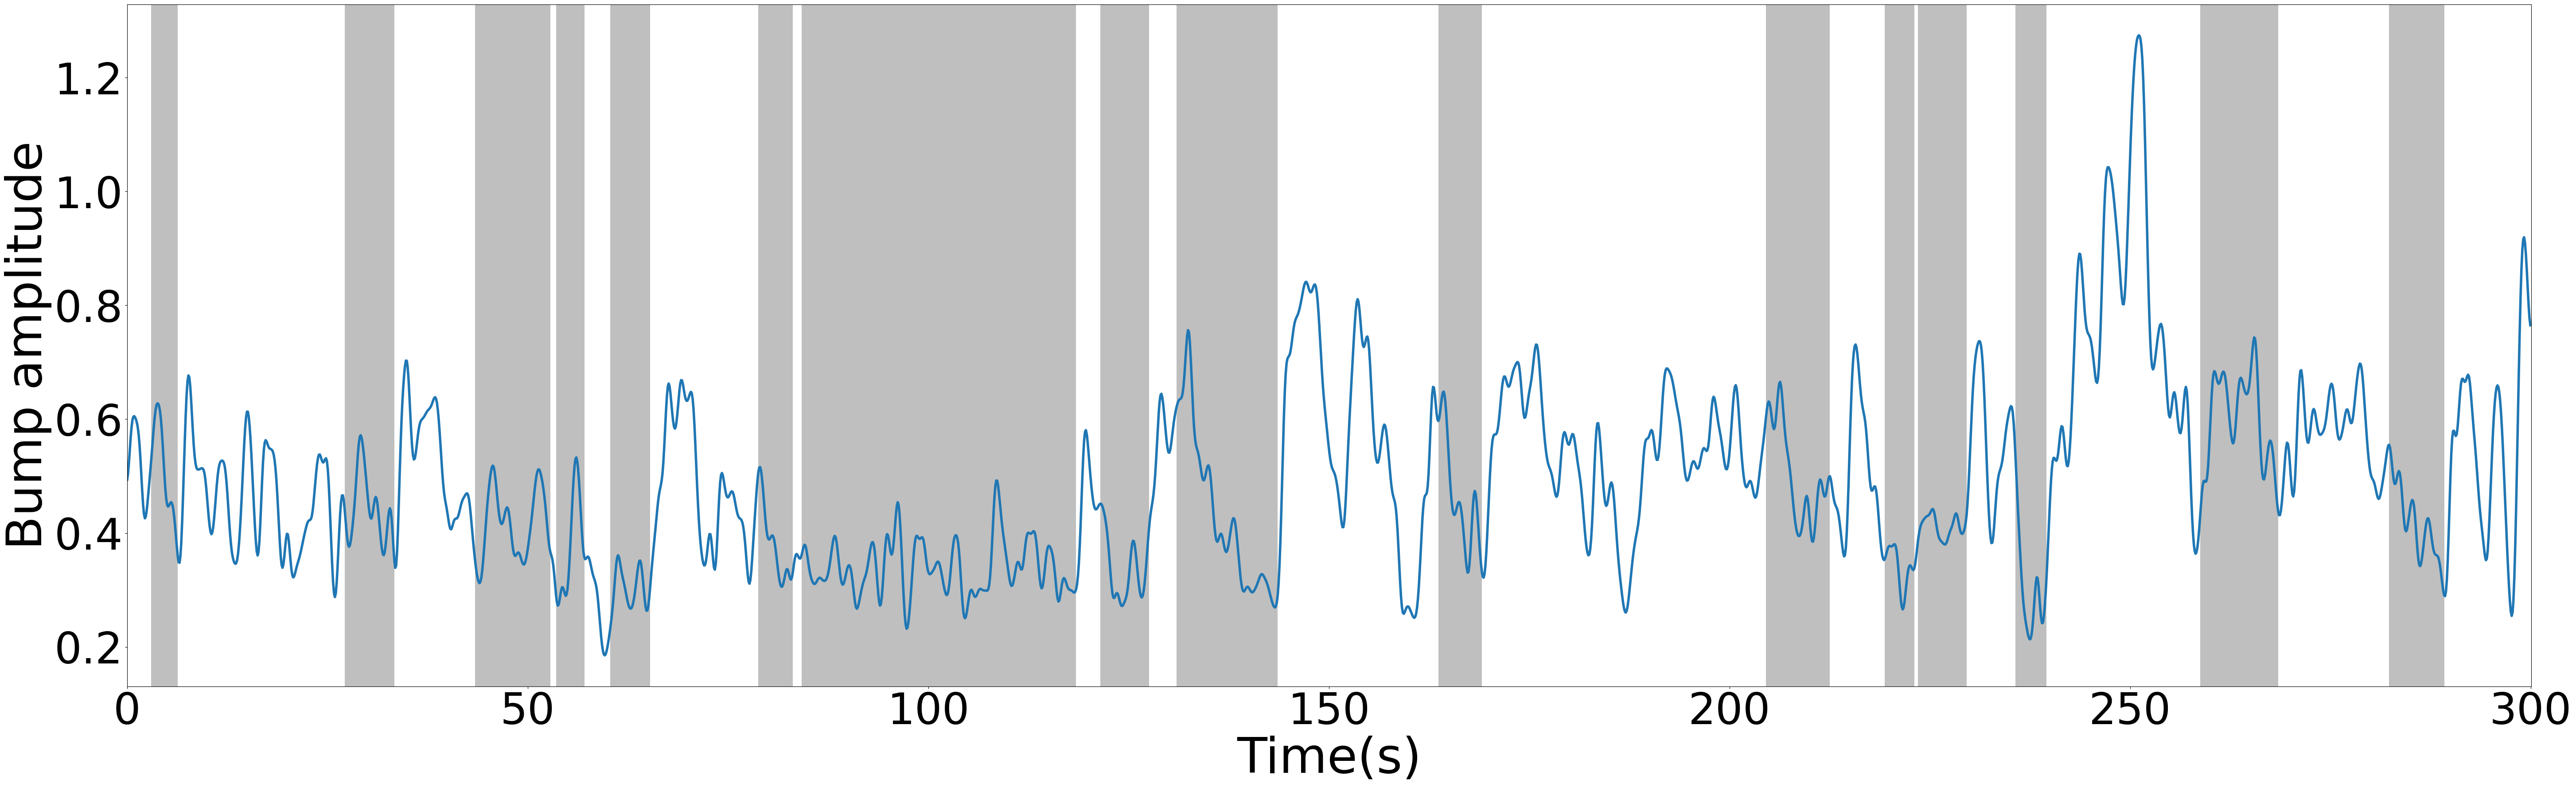

In [21]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(Bump_amplitude, sigma =3),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump amplitude', fontsize=80)
plt.show()

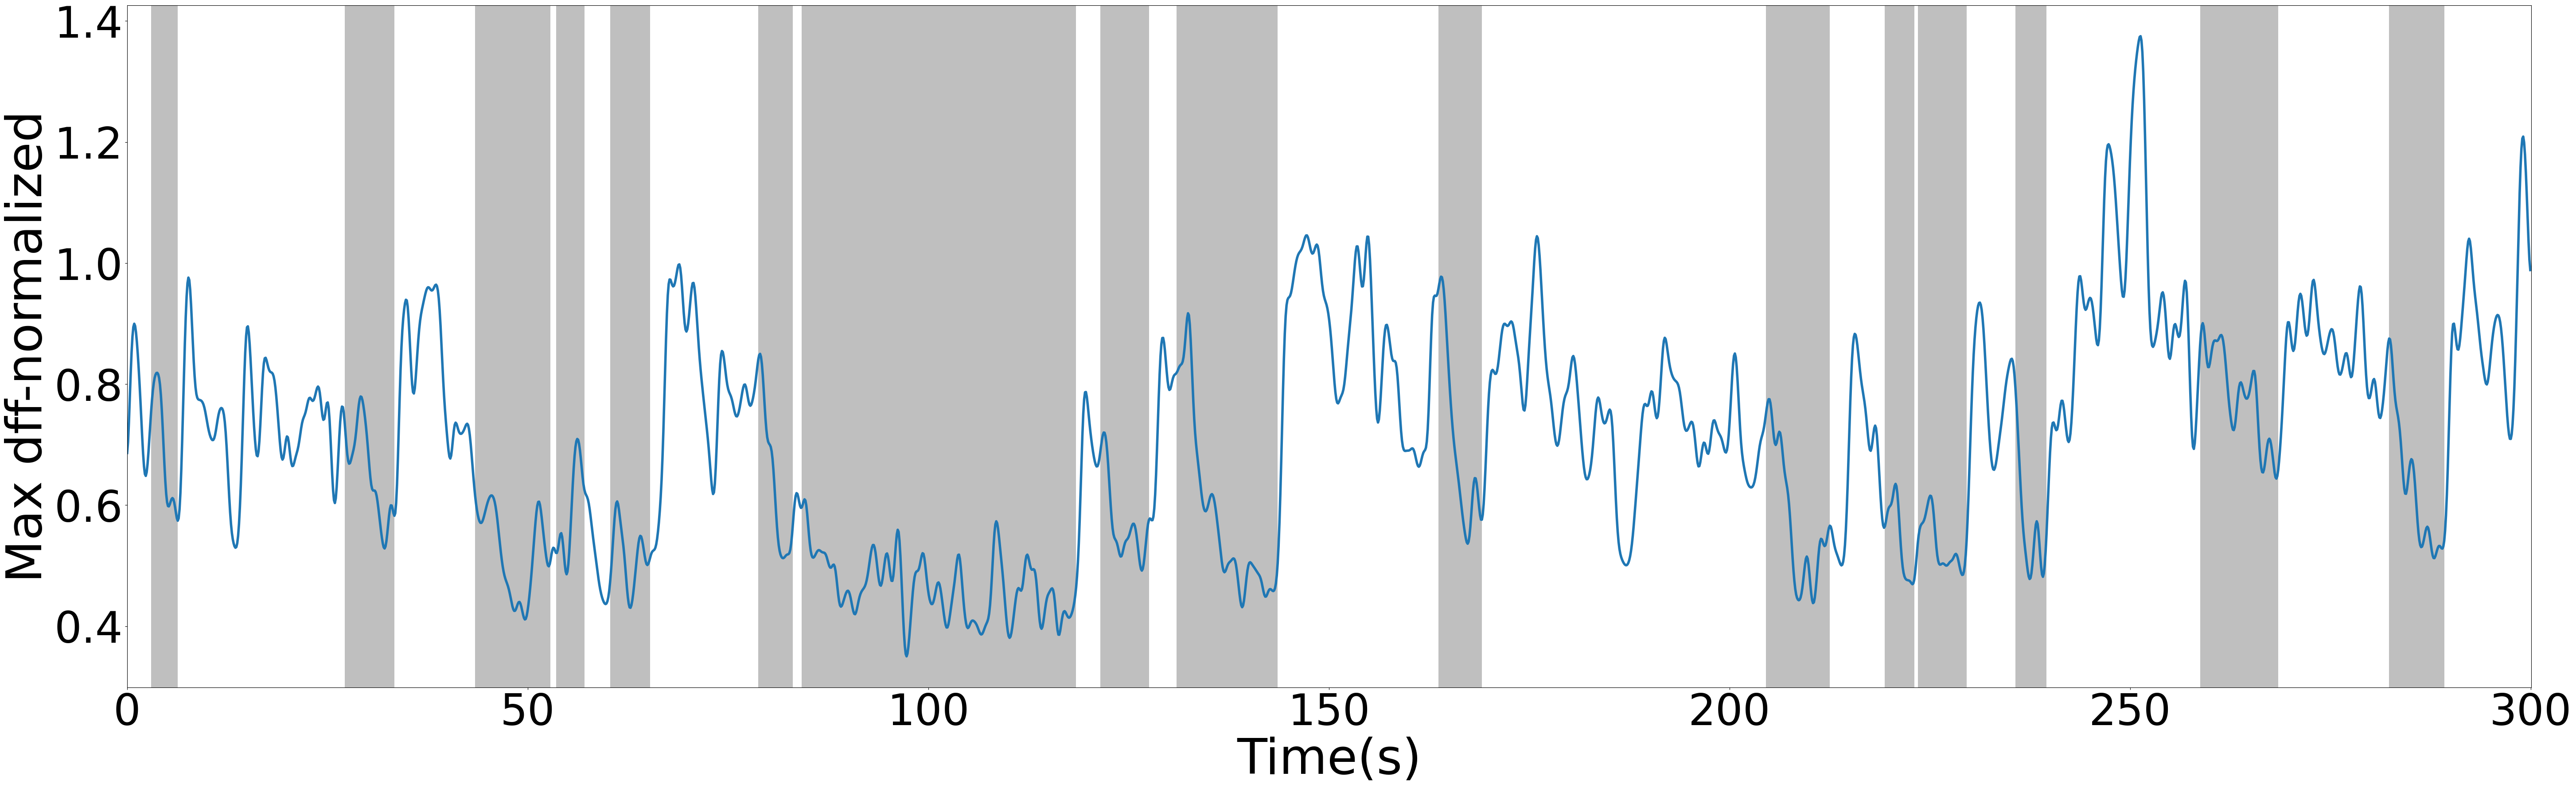

In [22]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(np.max(dff_normalized_8_roi,axis=1), sigma =3),linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Max dff-normalized', fontsize=80)
plt.show()
plt.show()

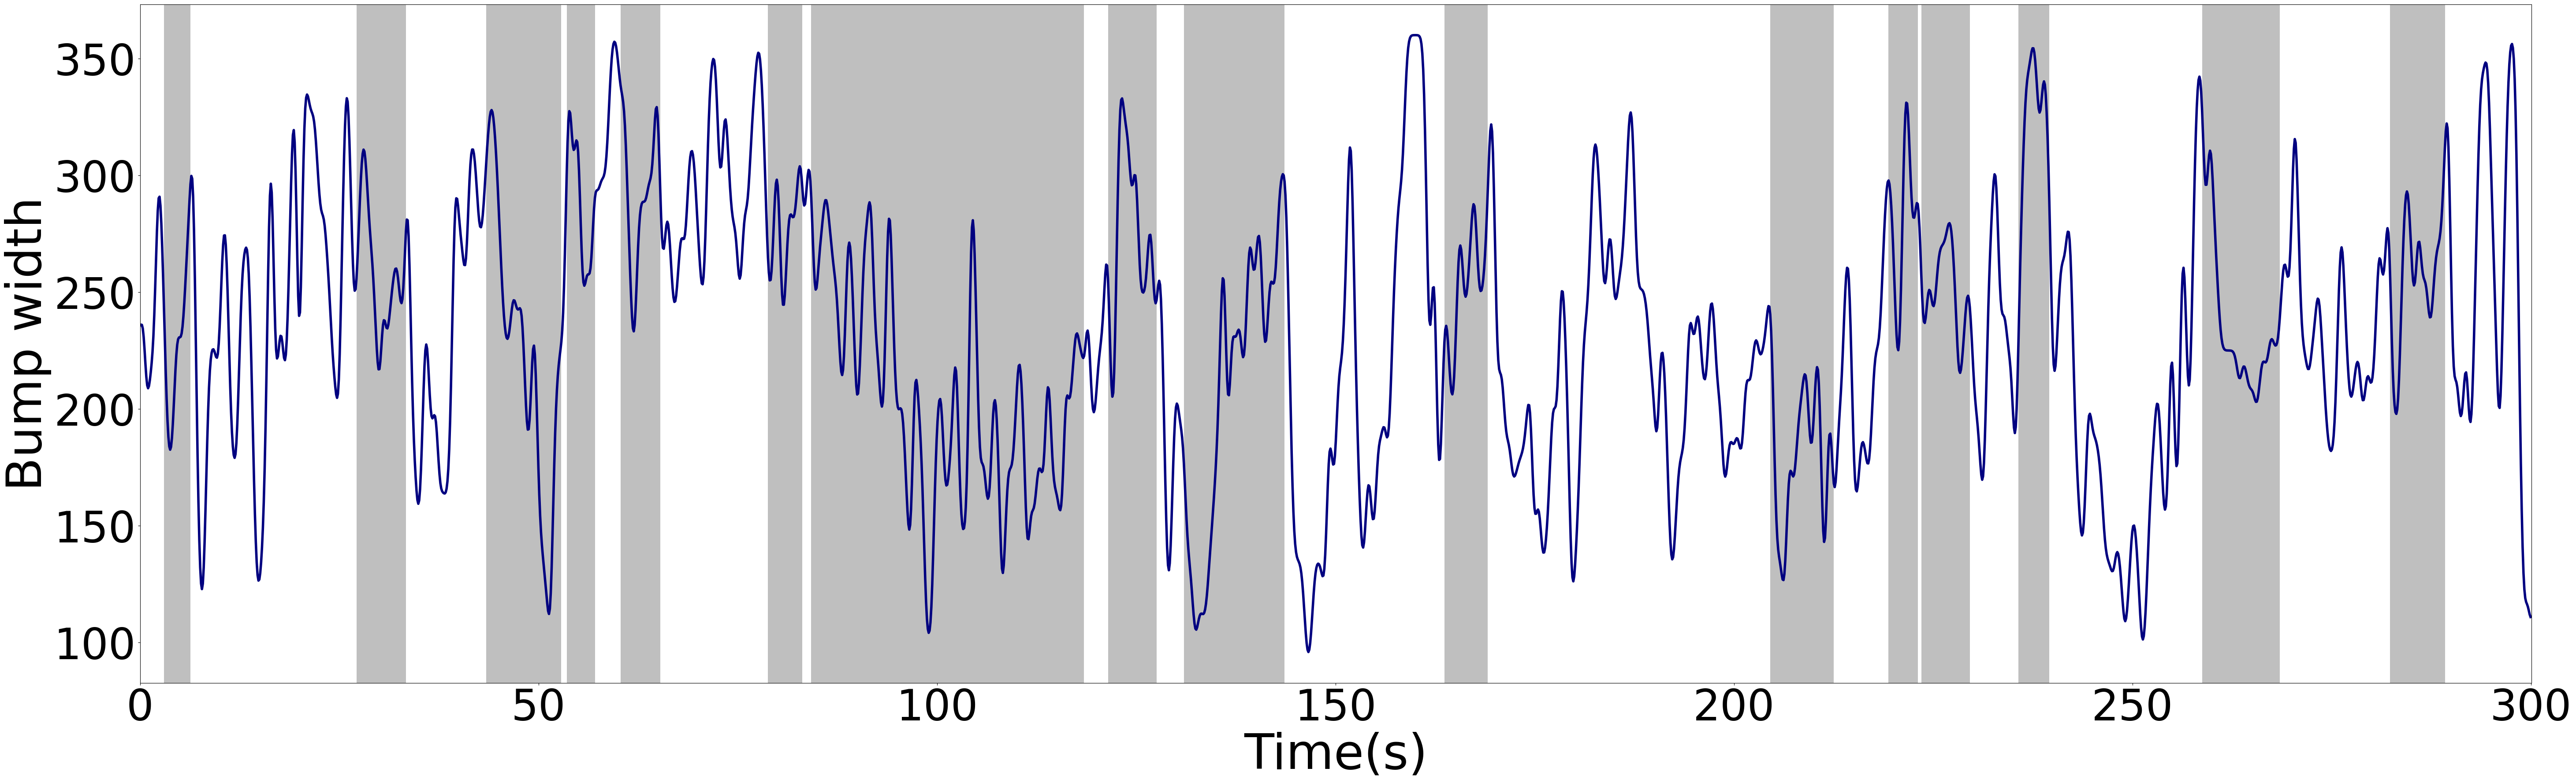

In [23]:
bump_width= calculateBumpWidth_v1(dff_normalized_8_roi,8)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(bump_width, sigma =3),linewidth =4, color ='navy')
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump width', fontsize=80)
plt.show()
plt.show()

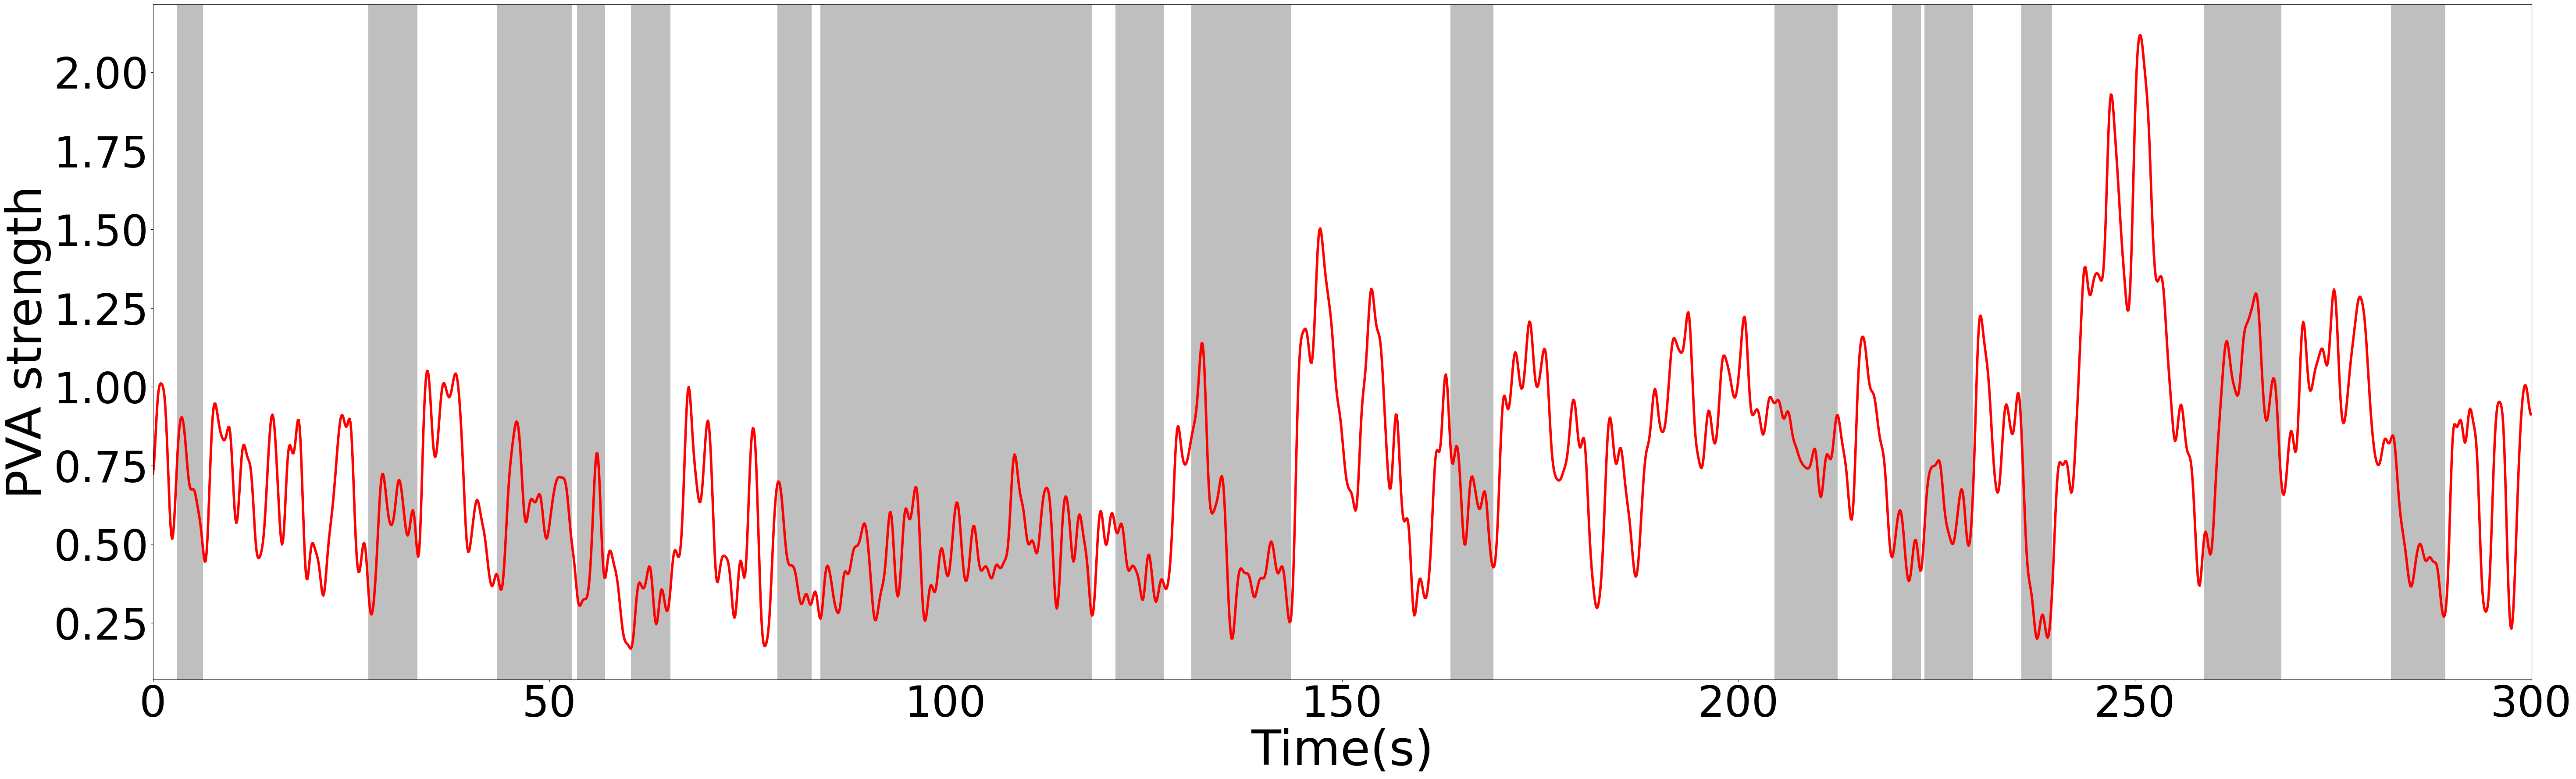

In [24]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(PVA_strength_no_series, sigma =3),color = 'r',linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('PVA strength', fontsize=80)
plt.show()

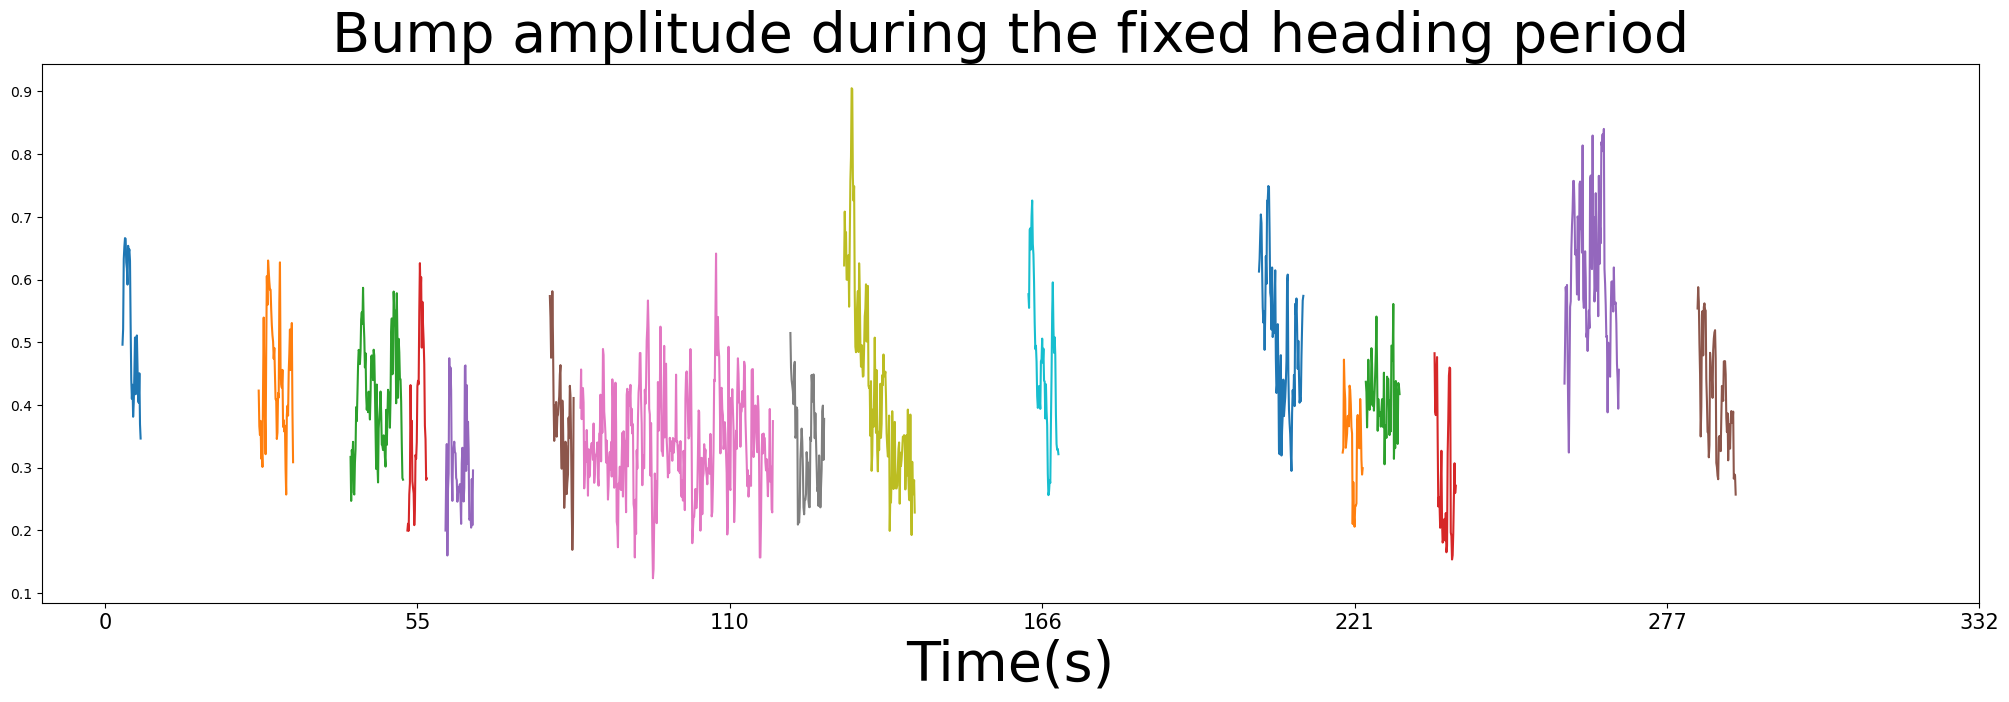

In [25]:
#Check bump amplitude during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Bump_amplitude[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

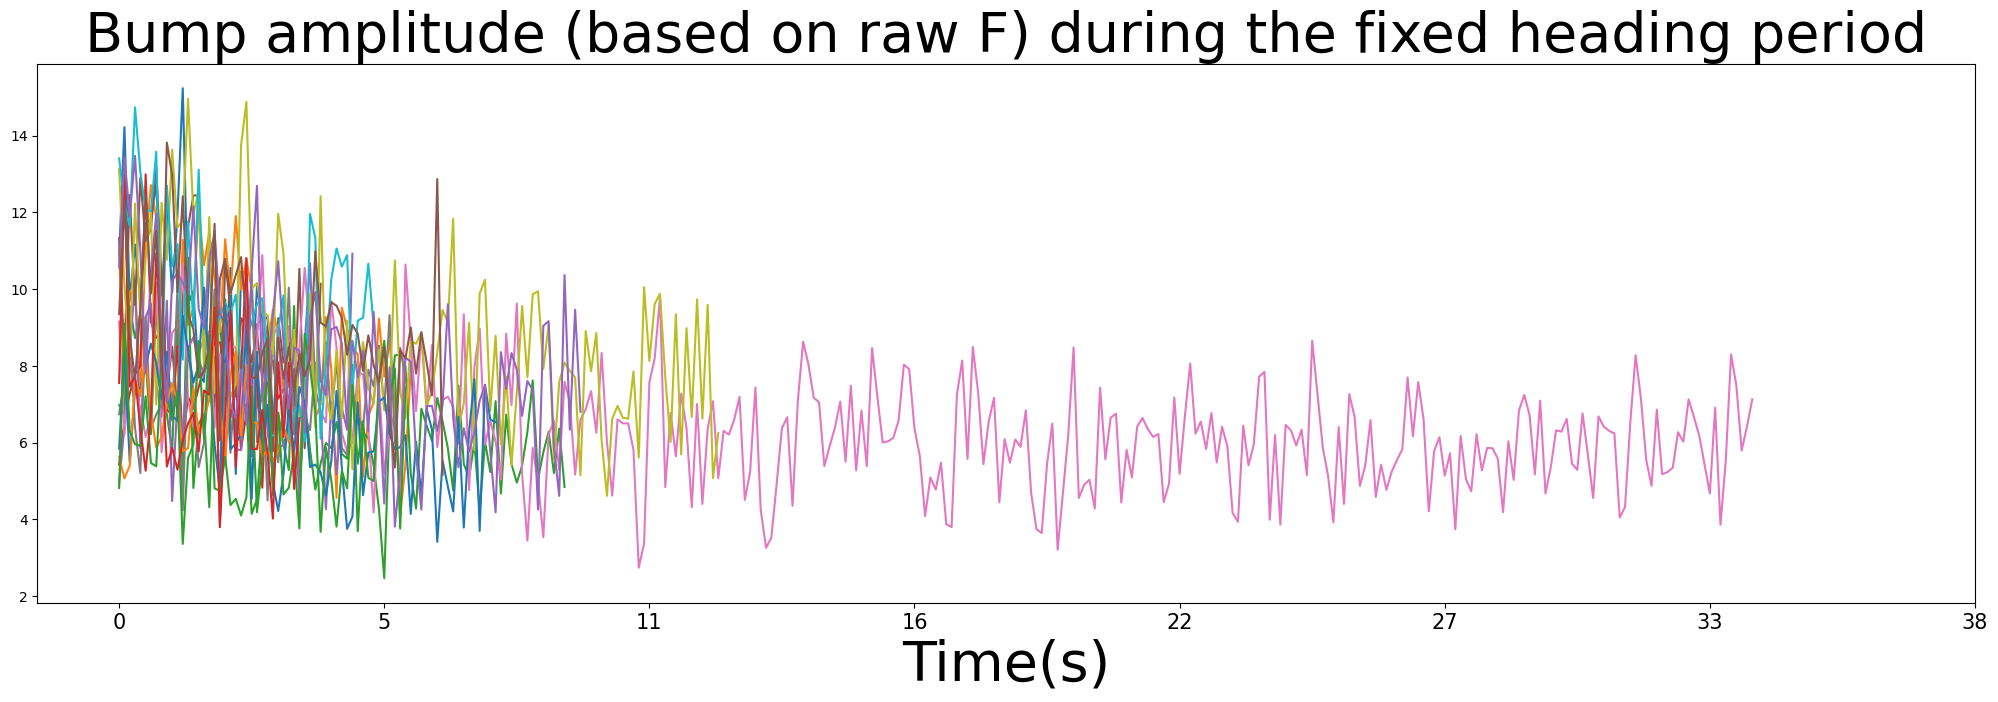

In [26]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(bump_amplitude_F[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.title('Bump amplitude (based on raw F) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

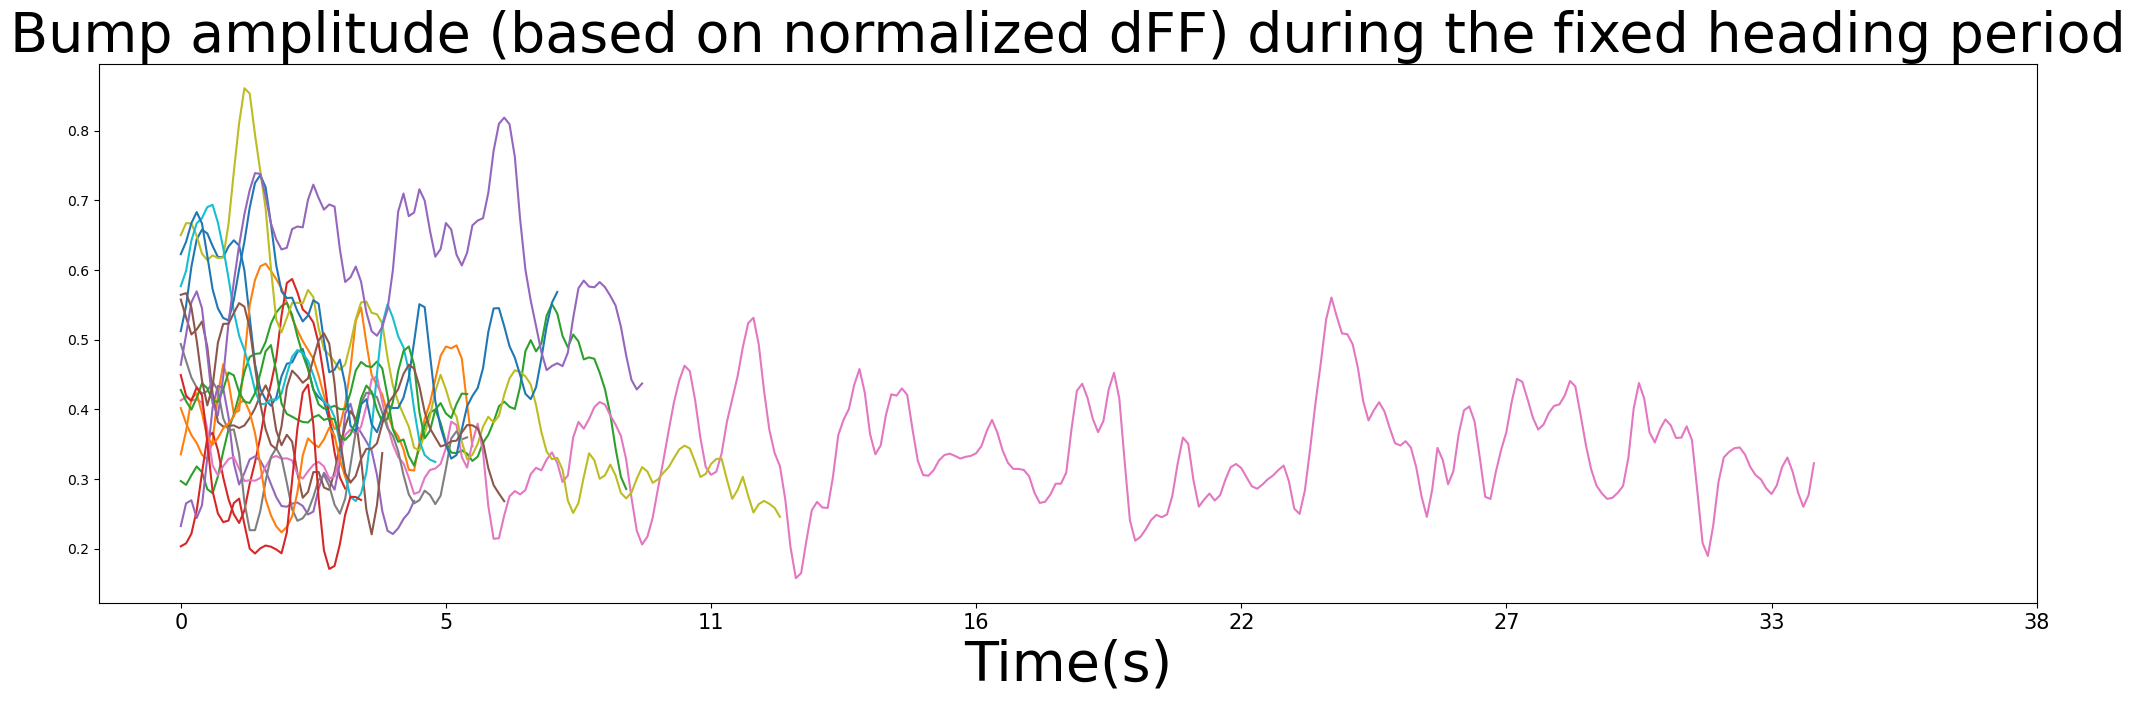

In [27]:
#Check bump amplitude (based on raw F) during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(gaussian_filter1d(Bump_amplitude_no_series[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1],sigma =1))
plt.title('Bump amplitude (based on normalized dFF) during the fixed heading period', fontsize =40)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.xlabel('Time(s)', fontsize=40)
plt.show()

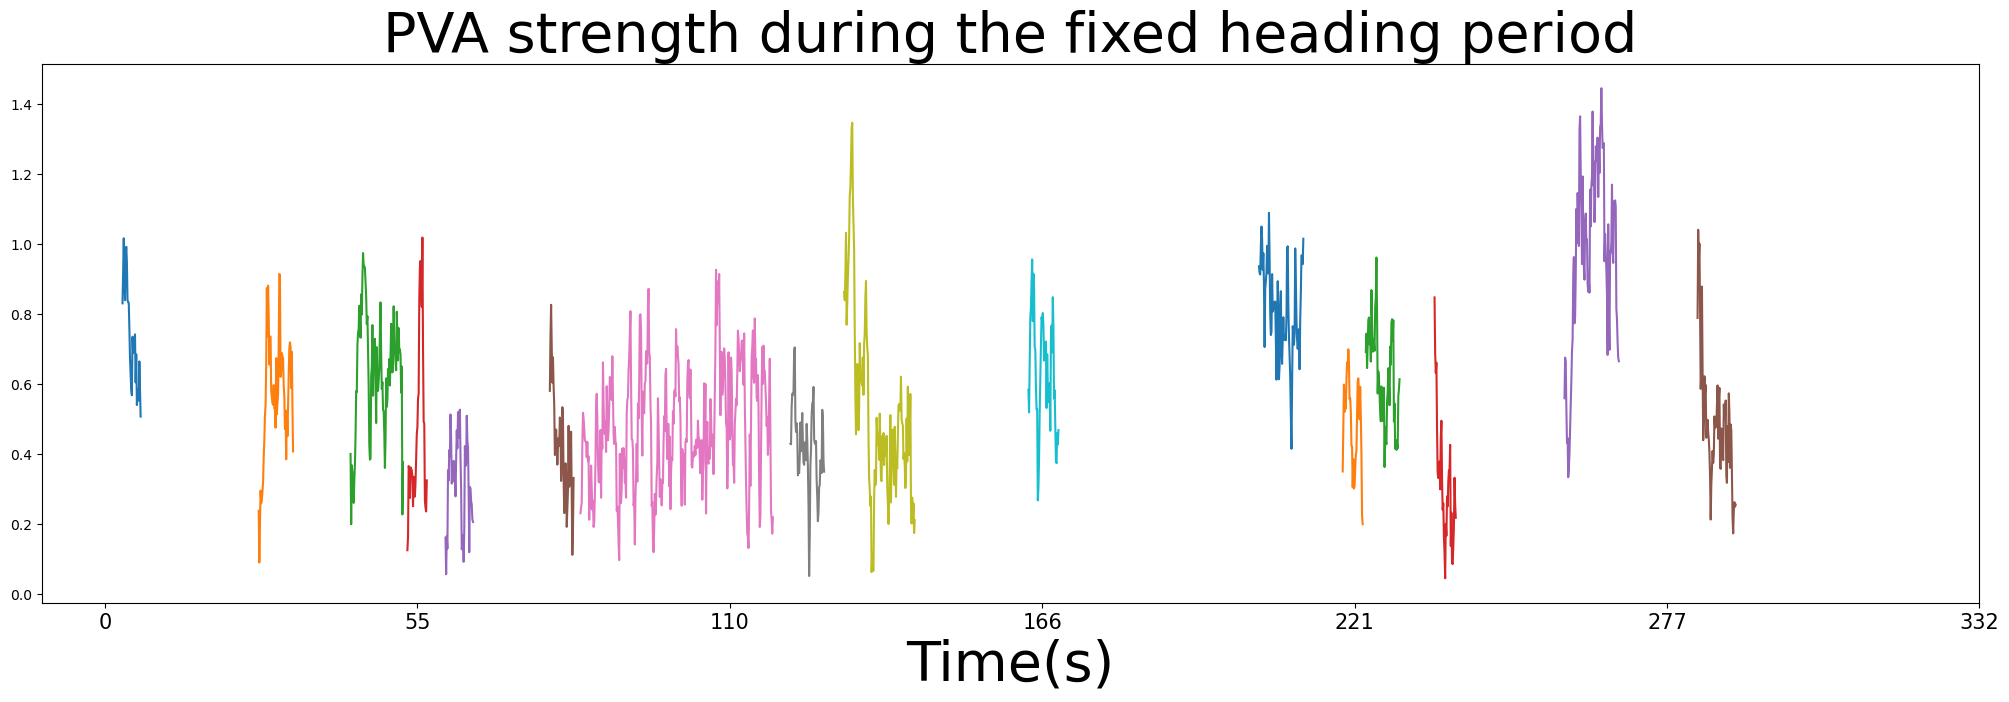

In [28]:
#Check PVA strength during the time of fixed-heading period
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(PVA_strength[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=15)
plt.title('PVA strength during the fixed heading period', fontsize =40)
plt.xlabel('Time(s)', fontsize=40)
plt.show()
    

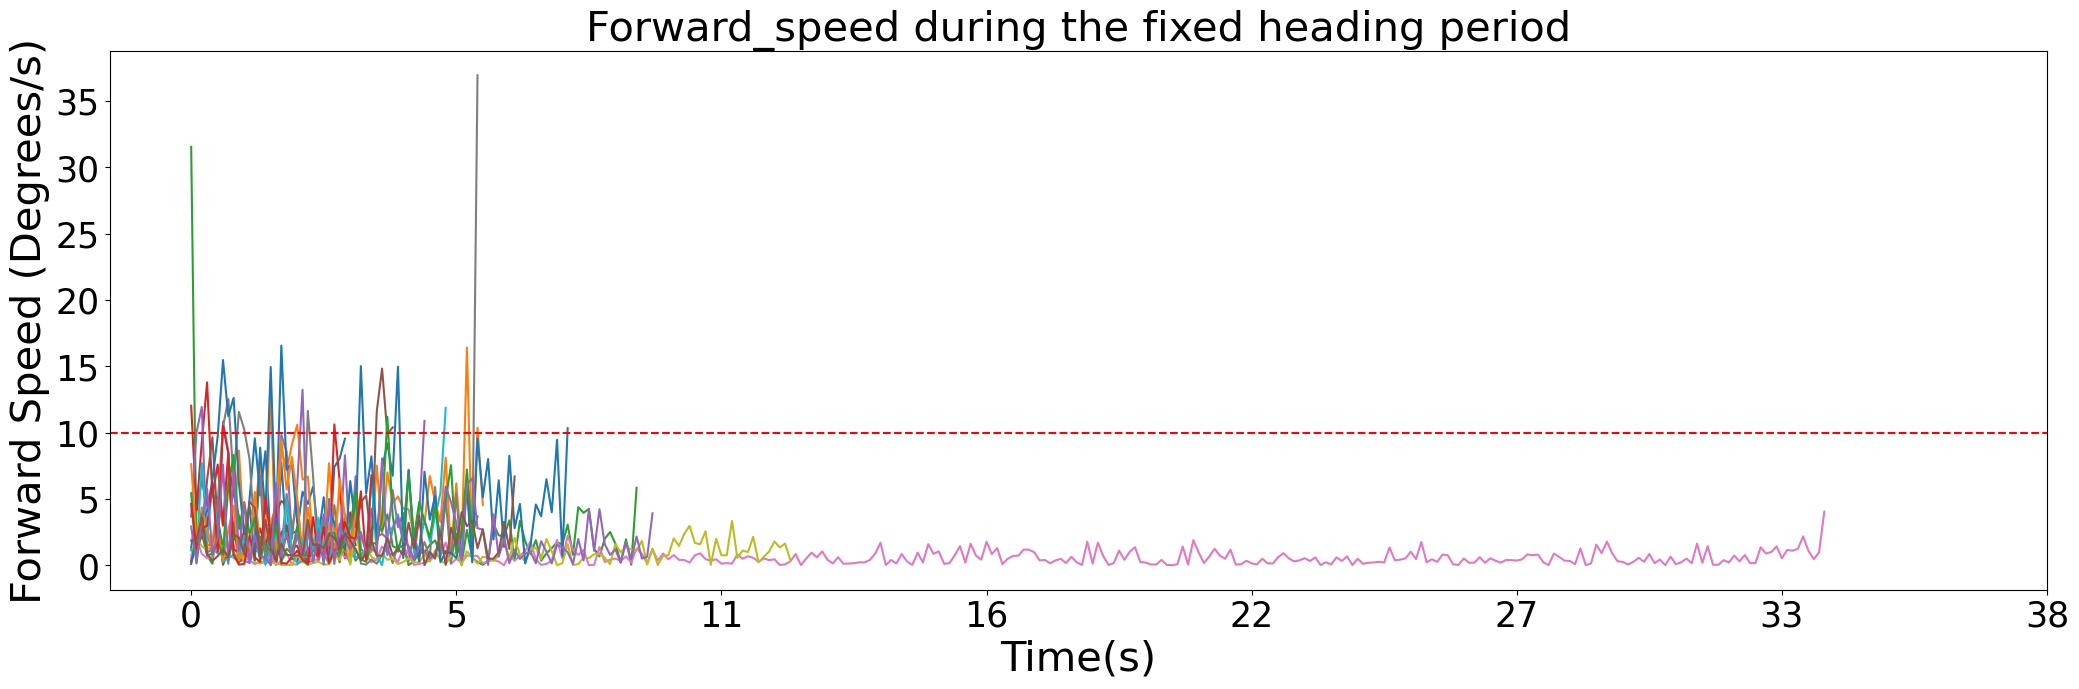

In [29]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

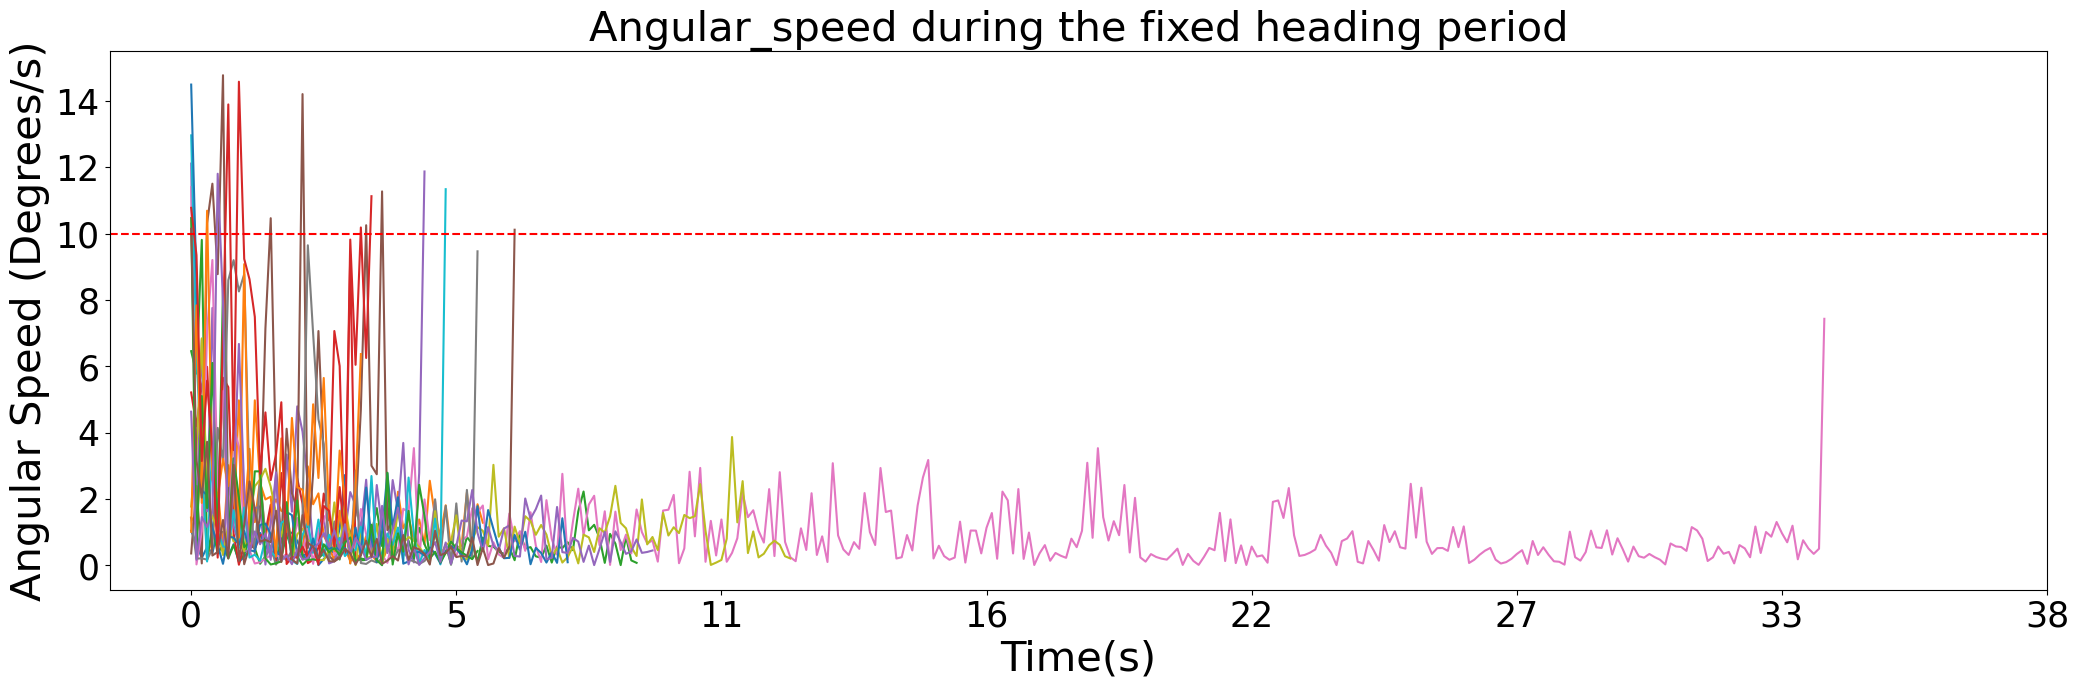

In [30]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(angular_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Angular_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 10, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Angular Speed (Degrees/s)', fontsize=30)
plt.show()
    

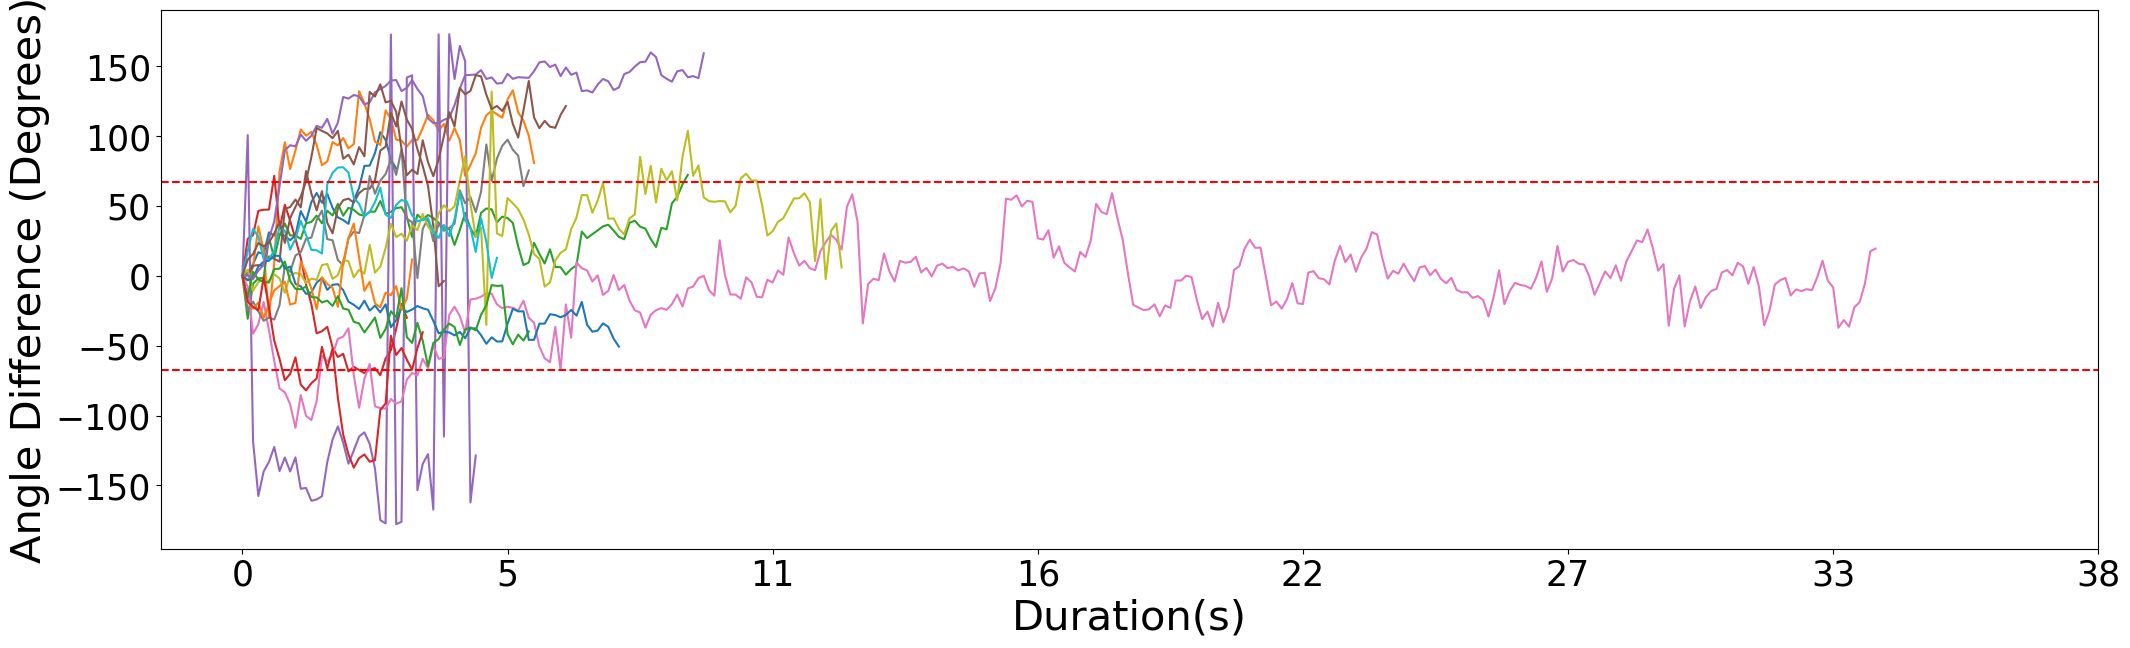

In [31]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    plt.plot(current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()
    

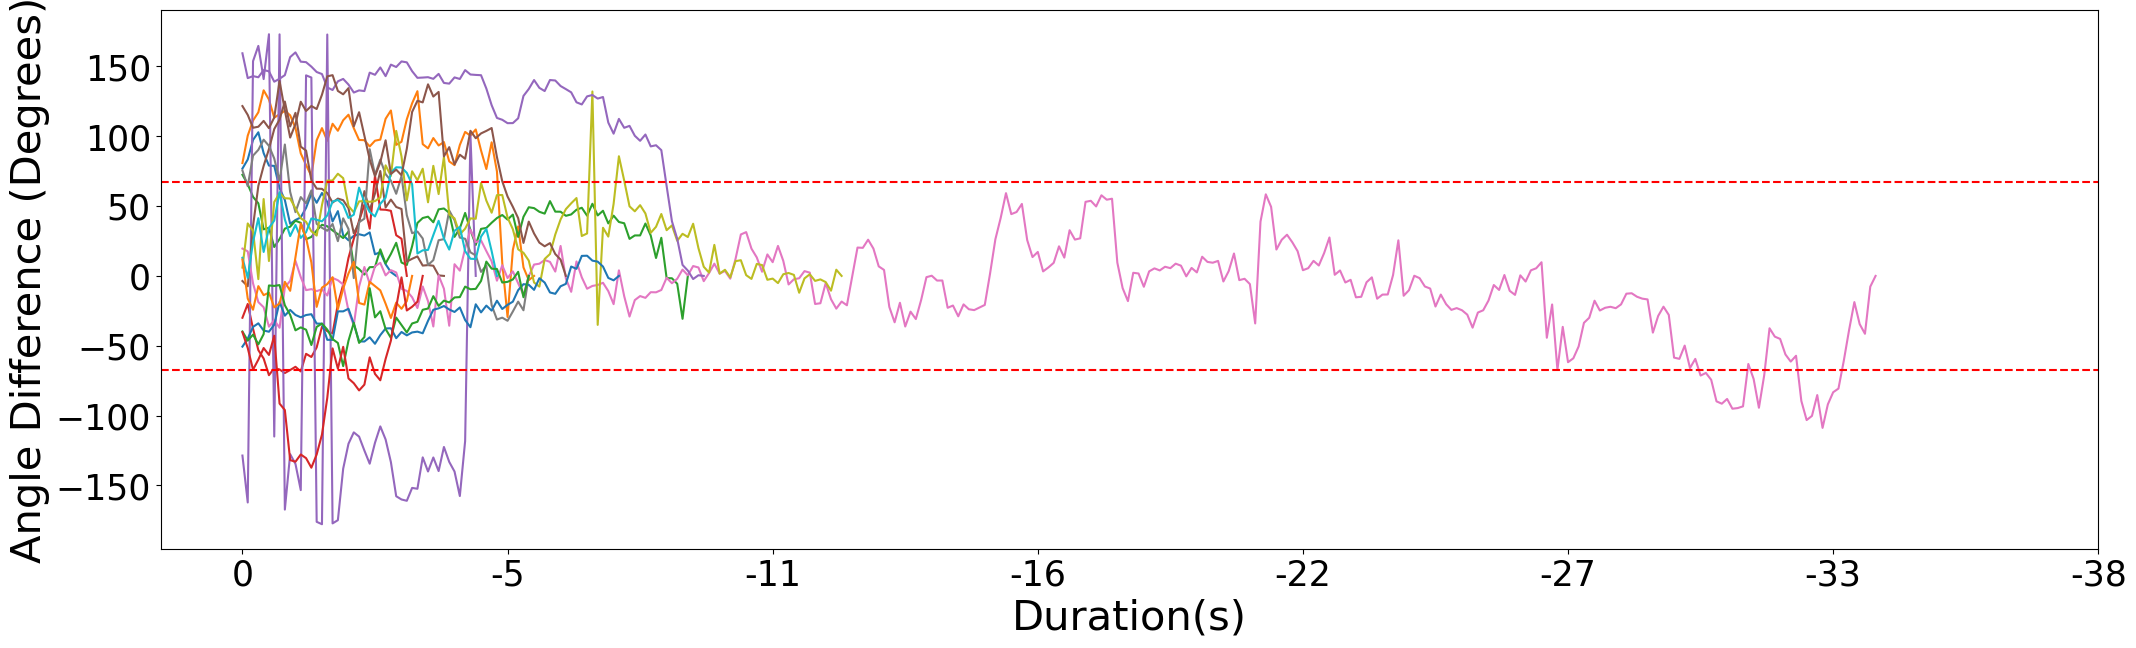

In [32]:
#Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [33]:
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly117-007')
PVA_angle_at_stop.insert(1,'Genotype','R60D05>sytGCaMP7f')
PVA_angle_at_stop.insert(2,'TrialType','dark')
PVA_angle_at_stop

FlyTrial           Genotype TrialType  Period_duration   
0   TQfly117-007  R60D05>sytGCaMP7f      dark           8.4630  \
1   TQfly117-007  R60D05>sytGCaMP7f      dark           5.4250   
2   TQfly117-007  R60D05>sytGCaMP7f      dark           5.2080   
3   TQfly117-007  R60D05>sytGCaMP7f      dark           6.8355   
4   TQfly117-007  R60D05>sytGCaMP7f      dark          16.0580   
5   TQfly117-007  R60D05>sytGCaMP7f      dark           3.6890   
6   TQfly117-007  R60D05>sytGCaMP7f      dark          38.5175   
7   TQfly117-007  R60D05>sytGCaMP7f      dark          17.2515   
8   TQfly117-007  R60D05>sytGCaMP7f      dark          17.7940   
9   TQfly117-007  R60D05>sytGCaMP7f      dark           9.2225   
10  TQfly117-007  R60D05>sytGCaMP7f      dark          81.2665   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         44.279491       30.686020                 31.460462  \
1         91.765990       98.914303                122.467355   
2         57.415172       46.779515                 41.302121   
3         60.365195       62.307997                 81.624939   
4         65.508621      128.346899                105.367060   
5         64.379502       93.486905                 96.632785   
6       -179.527326      123.879157                107.037449   
7        164.675995      108.897201               -143.459779   
8       -133.523031      -20.482459                -10.789552   
9        156.230453        0.648692                 13.862150   
10       107.396908       29.815567                 41.639101   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart   
0                  36.042475       4.738411              41.288244  \
1                 102.485911      95.339331             107.592243   
2                  56.299563      39.119697              40.033565   
3                  65.806060      23.077605              49.850690   
4                  69.244372      51.498078              62.641928   
5                 132.539344     109.691747             107.074040   
6                 128.884872     134.792679             127.137344   
7                   9.401835     158.456008              51.984448   
8                  12.324585     -92.259243              28.076093   
9                  -8.153532    -136.976649              -4.924598   
10                 35.745519      52.964880              30.533863   

    PVA_3s_after_stop  PVA_5s_after_stop  PVA_10s_after_stop   
0           33.193934          15.619574                 NaN  \
1          107.667511         121.581565                 NaN   
2           42.692245          41.302121                 NaN   
3           42.230347          35.355112                 NaN   
4           43.388754          50.365363           35.265034   
5          137.985838                NaN                 NaN   
6          150.716648         162.795457          141.205736   
7          117.561360         -31.796231           63.856611   
8          -19.724172           6.490022         -129.932283   
9          -60.722724          -9.505198                 NaN   
10         145.232167          97.676026           82.247714   

    PVA_35s_after_stop  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
5                  NaN  
6            96.631068  
7                  NaN  
8                  NaN  
9                  NaN  
10          110.030194

In [34]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

forward_speed_before_stop  forward_speed_at_restart   
0                    3.644852                  7.700882  \
1                    2.503883                  0.296307   
2                    0.838349                  2.938754   
3                    6.124051                  0.421526   
4                    1.086613                 13.911855   
5                    0.773396                  0.488405   
6                    4.113953                 12.133129   
7                    0.733426                  3.044000   
8                    4.970097                  0.505918   
9                    1.063086                  1.870707   
10                   2.434079                  3.170218   

    forward_speed_100ms_before_restart  forward_speed_500ms_before_restart   
0                             8.831790                            3.822206  \
1                             0.173187                            0.385490   
2                             2.086945                            1.731536   
3                             1.784641                            0.253043   
4                             2.296795                            0.829855   
5                             0.643145                            2.845836   
6                            10.704848                            3.096888   
7                             1.526287                            3.097769   
8                             3.344868                            0.226032   
9                             6.334914                            3.769487   
10                            7.642328                            0.156653   

    forward_speed_in_middle  forward_speed_2s_before_restart   
0                  0.529103                         0.247439  \
1                  6.308190                         0.256168   
2                  4.548909                         2.061259   
3                  0.120892                         0.468755   
4                  0.537285                         0.363143   
5                 11.185385                         9.265204   
6                  0.120694                         2.323174   
7                  2.283253                         1.219578   
8                  1.801924                         6.552956   
9                  6.814487                         1.830597   
10                 0.665832                         3.790513   

    forward_speed_3s_after_stop  forward_speed_5s_after_stop   
0                      2.234479                     1.982724  \
1                      4.648957                     5.941455   
2                      1.887835                     2.086945   
3                      4.434521                     1.352817   
4                      0.172799                     4.763797   
5                      7.399433                          NaN   
6                      0.127978                     1.008283   
7                      2.016688                     2.225652   
8                      8.380184                     1.565198   
9                      3.256293                     3.383402   
10                     0.036843                     2.048878   

    forward_speed_10s_after_stop  forward_speed_35s_after_stop  
0                            NaN                           NaN  
1                            NaN                           NaN  
2                            NaN                           NaN  
3                            NaN                           NaN  
4                       1.075421                           NaN  
5                            NaN                           NaN  
6                       0.289759                      2.295273  
7                       2.611654                           NaN  
8                       0.519693                           NaN  
9                            NaN                           NaN  
10                      1.154739                      0.251941

In [35]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_no_series, volume_time=volume_time)
Bump_amplitude_at_stop

bump_amplitude_before_stop  bump_amplitude_at_restart   
0                     1.198626                   0.799136  \
1                     0.894260                   0.532005   
2                     1.024957                   0.818752   
3                     0.823433                   0.267026   
4                     0.404437                   0.272119   
5                     0.367230                   0.788899   
6                     0.918970                   0.453057   
7                     0.734004                   0.125712   
8                     0.355273                   0.155064   
9                     0.167603                   0.188129   
10                    0.673303                   0.302201   

    bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                              0.935745                             0.730875  \
1                              0.675918                             0.569682   
2                              0.786244                             0.283003   
3                              0.247161                             0.452873   
4                              0.346553                             0.489389   
5                              0.827051                             0.580144   
6                              0.609005                             0.332490   
7                              0.296185                             0.323687   
8                              0.149818                             0.322650   
9                              0.209681                             0.195464   
10                             0.367186                             0.361297   

    bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                   0.626632                          0.607221  \
1                   0.834190                          0.661280   
2                   0.977091                          0.942561   
3                   0.346430                          0.284358   
4                   0.491916                          0.345972   
5                   0.580030                          0.544607   
6                   0.420570                          0.221960   
7                   0.173554                          0.425610   
8                   0.197087                          0.266097   
9                   0.359443                          0.168334   
10                  0.250917                          0.225140   

    bump_amplitude_3s_after_stop  bump_amplitude_5s_after_stop   
0                       0.664407                      0.747217  \
1                       0.734069                      0.699774   
2                       0.896743                      0.786244   
3                       0.150241                      0.332363   
4                       0.510911                      0.541136   
5                       0.750306                           NaN   
6                       0.602139                      0.338187   
7                       0.217172                      0.321955   
8                       0.264946                      0.262810   
9                       0.170474                      0.228430   
10                      0.561136                      0.615245   

    bump_amplitude_10s_after_stop  bump_amplitude_35s_after_stop  
0                             NaN                            NaN  
1                             NaN                            NaN  
2                             NaN                            NaN  
3                             NaN                            NaN  
4                        0.381274                            NaN  
5                             NaN                            NaN  
6                        0.464277                       0.264661  
7                        0.268655                            NaN  
8                        0.278828                            NaN  
9                             NaN                     

In [36]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

FlyTrial           Genotype TrialType  Period_duration   
0   TQfly117-007  R60D05>sytGCaMP7f      dark           8.4630  \
1   TQfly117-007  R60D05>sytGCaMP7f      dark           5.4250   
2   TQfly117-007  R60D05>sytGCaMP7f      dark           5.2080   
3   TQfly117-007  R60D05>sytGCaMP7f      dark           6.8355   
4   TQfly117-007  R60D05>sytGCaMP7f      dark          16.0580   
5   TQfly117-007  R60D05>sytGCaMP7f      dark           3.6890   
6   TQfly117-007  R60D05>sytGCaMP7f      dark          38.5175   
7   TQfly117-007  R60D05>sytGCaMP7f      dark          17.2515   
8   TQfly117-007  R60D05>sytGCaMP7f      dark          17.7940   
9   TQfly117-007  R60D05>sytGCaMP7f      dark           9.2225   
10  TQfly117-007  R60D05>sytGCaMP7f      dark          81.2665   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         44.279491       30.686020                 31.460462  \
1         91.765990       98.914303                122.467355   
2         57.415172       46.779515                 41.302121   
3         60.365195       62.307997                 81.624939   
4         65.508621      128.346899                105.367060   
5         64.379502       93.486905                 96.632785   
6       -179.527326      123.879157                107.037449   
7        164.675995      108.897201               -143.459779   
8       -133.523031      -20.482459                -10.789552   
9        156.230453        0.648692                 13.862150   
10       107.396908       29.815567                 41.639101   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                  36.042475       4.738411              41.288244  ...  \
1                 102.485911      95.339331             107.592243  ...   
2                  56.299563      39.119697              40.033565  ...   
3                  65.806060      23.077605              49.850690  ...   
4                  69.244372      51.498078              62.641928  ...   
5                 132.539344     109.691747             107.074040  ...   
6                 128.884872     134.792679             127.137344  ...   
7                   9.401835     158.456008              51.984448  ...   
8                  12.324585     -92.259243              28.076093  ...   
9                  -8.153532    -136.976649              -4.924598  ...   
10                 35.745519      52.964880              30.533863  ...   

    bump_amplitude_before_stop  bump_amplitude_at_restart   
0                     1.198626                   0.799136  \
1                     0.894260                   0.532005   
2                     1.024957                   0.818752   
3                     0.823433                   0.267026   
4                     0.404437                   0.272119   
5                     0.367230                   0.788899   
6                     0.918970                   0.453057   
7                     0.734004                   0.125712   
8                     0.355273                   0.155064   
9                     0.167603                   0.188129   
10                    0.673303                   0.302201   

    bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                              0.935745                             0.730875  \
1                              0.675918                             0.569682   
2                              0.786244                             0.283003   
3                              0.247161                             0.452873   
4                              0.346553                             0.489389   
5                              0.827051                             0.580144   
6                              0.609005                             0.332490   
7                              0.296185                             0.323687   
8                              0.149818                             0.322650   


In [37]:
output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/EPG_EB(syt)/TQfly117-007-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [38]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/EPG_EB(syt)')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

FlyTrial           Genotype TrialType  Period_duration   
0    TQfly107-004  R60D05>sytGCaMP7f      dark          4.67460  \
1    TQfly107-004  R60D05>sytGCaMP7f      dark         15.06260   
2    TQfly107-004  R60D05>sytGCaMP7f      dark          3.11640   
3    TQfly107-004  R60D05>sytGCaMP7f      dark          8.10264   
4    TQfly107-004  R60D05>sytGCaMP7f      dark          6.12892   
..            ...                ...       ...              ...   
268  TQfly107-001  R60D05>sytGCaMP7f      dark          8.51816   
269  TQfly107-001  R60D05>sytGCaMP7f      dark          9.14144   
270  TQfly107-001  R60D05>sytGCaMP7f      dark         37.60456   
271  TQfly107-001  R60D05>sytGCaMP7f      dark         16.51692   
272  TQfly107-001  R60D05>sytGCaMP7f      dark         16.10140   

     PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0          67.496482       61.444742                 62.244164  \
1        -100.439200      -52.081309                -54.191939   
2         108.825620       90.786107                 93.024436   
3        -175.005491      160.258099               -175.398096   
4         151.202858     -169.385501               -165.845382   
..               ...             ...                       ...   
268        84.250258       64.783968                 57.720177   
269       -53.859144      -70.427719                -71.579175   
270        39.163967       37.549947                 38.199725   
271       136.893773      130.647250                127.136106   
272       134.484826      154.864001                147.167326   

     PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                   65.867424     102.421370              80.175262  ...  \
1                  -67.096693     -41.194179             -66.413466  ...   
2                  105.653046     109.529010             105.407653  ...   
3                 -169.242274    -179.376721            -166.017264  ...   
4                 -164.544356    -158.123928            -168.121980  ...   
..                        ...            ...                    ...  ...   
268                 62.433917      69.820527              65.322089  ...   
269                -55.449159    -107.014921             -49.776629  ...   
270                 48.773165      48.353574              64.982880  ...   
271                147.913458     122.894729             122.382158  ...   
272                135.529996     154.028747             162.969924  ...   

     bump_amplitude_before_stop  bump_amplitude_at_restart   
0                      0.736225                   1.396698  \
1                      0.822800                   0.483450   
2                      1.182644                   1.462133   
3                      0.937973                   0.625250   
4                      0.427417                   0.508911   
..                          ...                        ...   
268                    0.584515                   0.766536   
269                    0.582992                   0.641605   
270                    0.783746                   0.923578   
271                    0.994583                   0.730419   
272                    0.844106                   0.529128   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               1.275751                             1.228551  \
1                               0.488757                             0.565667   
2                               1.213214                             1.116197   
3                               0.730122                             0.514224   
4                               0.472316                             0.573633   
..                                   ...                                  ...   
268                             0.725949                             0.543976   
269                             0.664602                             0.544352   
270                     

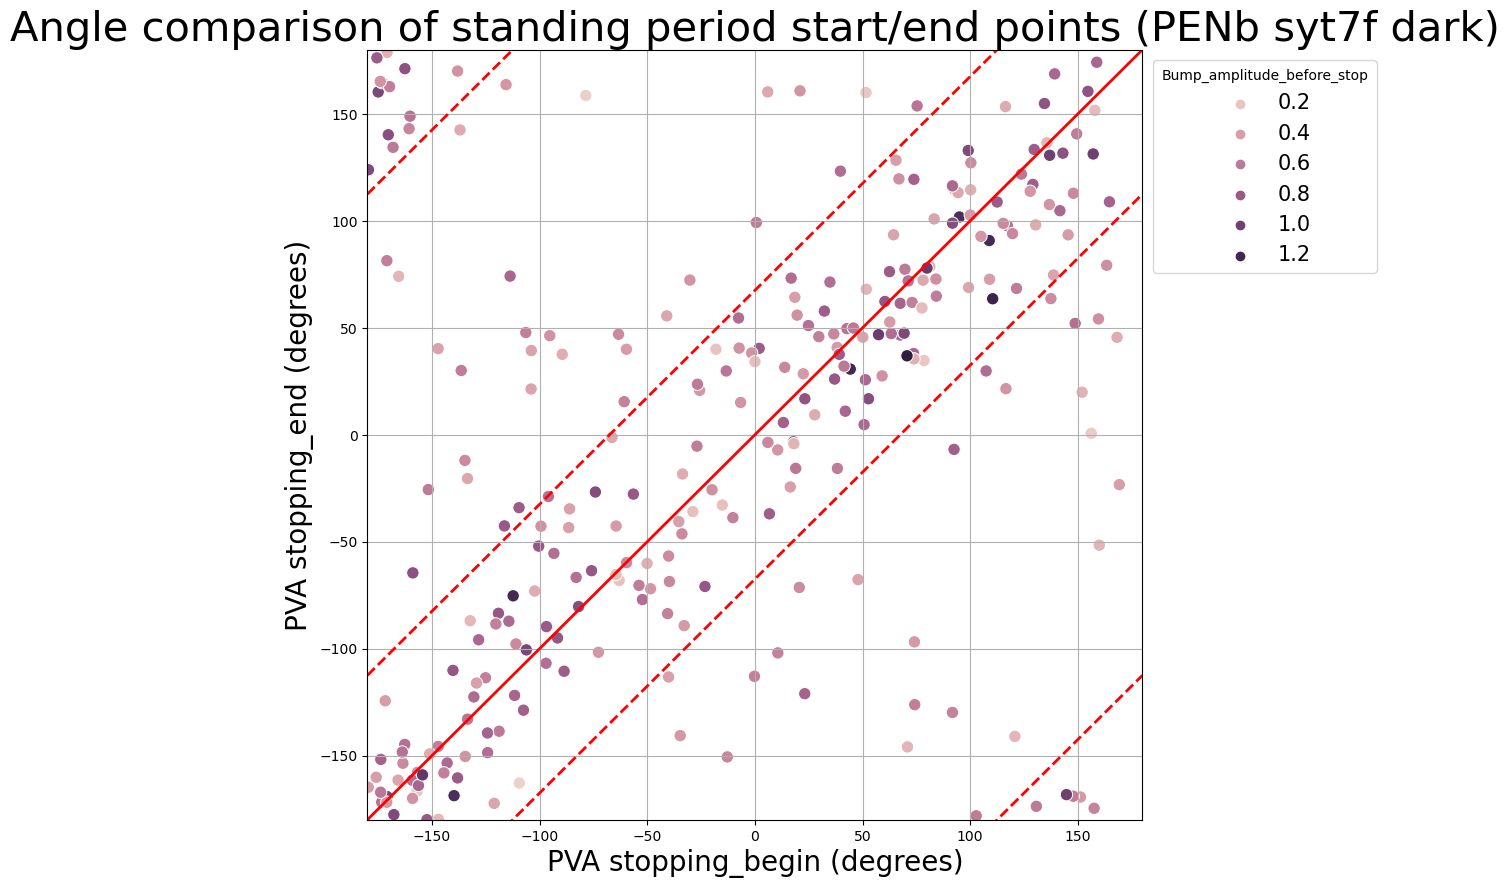

In [39]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (PENb syt7f dark)', fontsize =30)
plt.ylabel('PVA stopping_end (degrees)',fontsize= 20)
plt.xlabel('PVA stopping_begin (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.grid()
plt.show()

In [40]:
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(persistence_data_pooled['PVA_before_stop'])

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(persistence_data_pooled['PVA_before_stop'],size = pair_num)
    random_stop_end_angle = np.random.choice(persistence_data_pooled['PVA_at_restart'],size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))    

In [41]:
actual_angle_diff = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])
actual_mean_absolute_angle_diff = np.mean(np.abs(actual_angle_diff))
actual_mean_absolute_angle_diff 

42.91943198585035

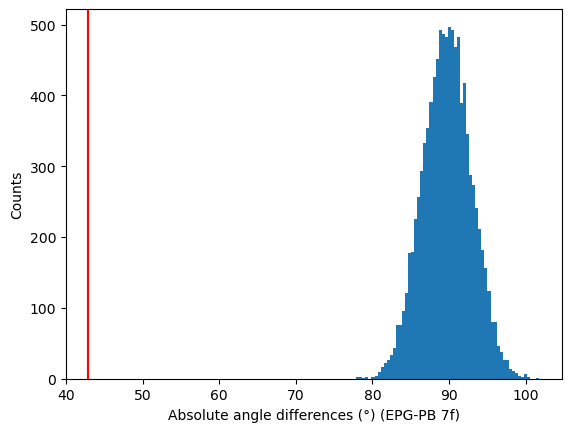

In [42]:
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff, color = 'r')
plt.xlabel('Absolute angle differences (°) (EPG-PB 7f)')
plt.ylabel('Counts')
plt.show()

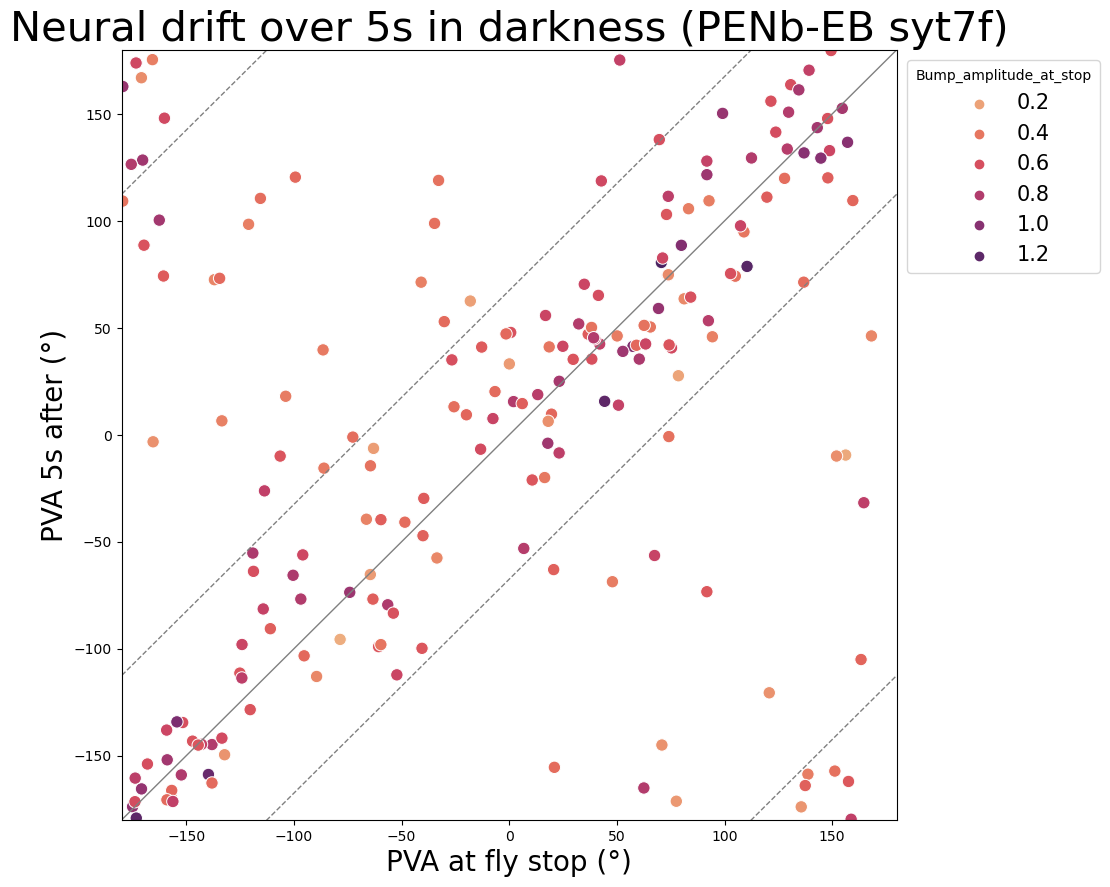

In [43]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_5s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 5s in darkness (PENb-EB syt7f)', fontsize =30)
plt.ylabel('PVA 5s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()

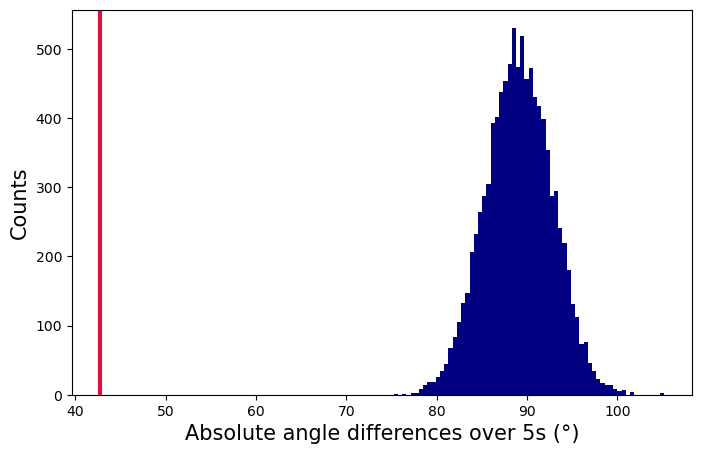

In [44]:
stop_period_start_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)))
stop_period_end_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)
for i in range(len(stop_period_start_5s )):
    stop_period_start_5s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_5s[i] =  persistence_data_pooled['PVA_5s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_5s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_5s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_5s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_5s =  calculate_angle_difference_between_two_time_point(stop_period_start_5s ,stop_period_end_5s)
actual_mean_absolute_angle_diff_5s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_5s))
actual_mean_absolute_angle_diff_5s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto', color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_5s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 5s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()   

In [45]:
actual_mean_absolute_angle_diff_5s

42.74586252040266

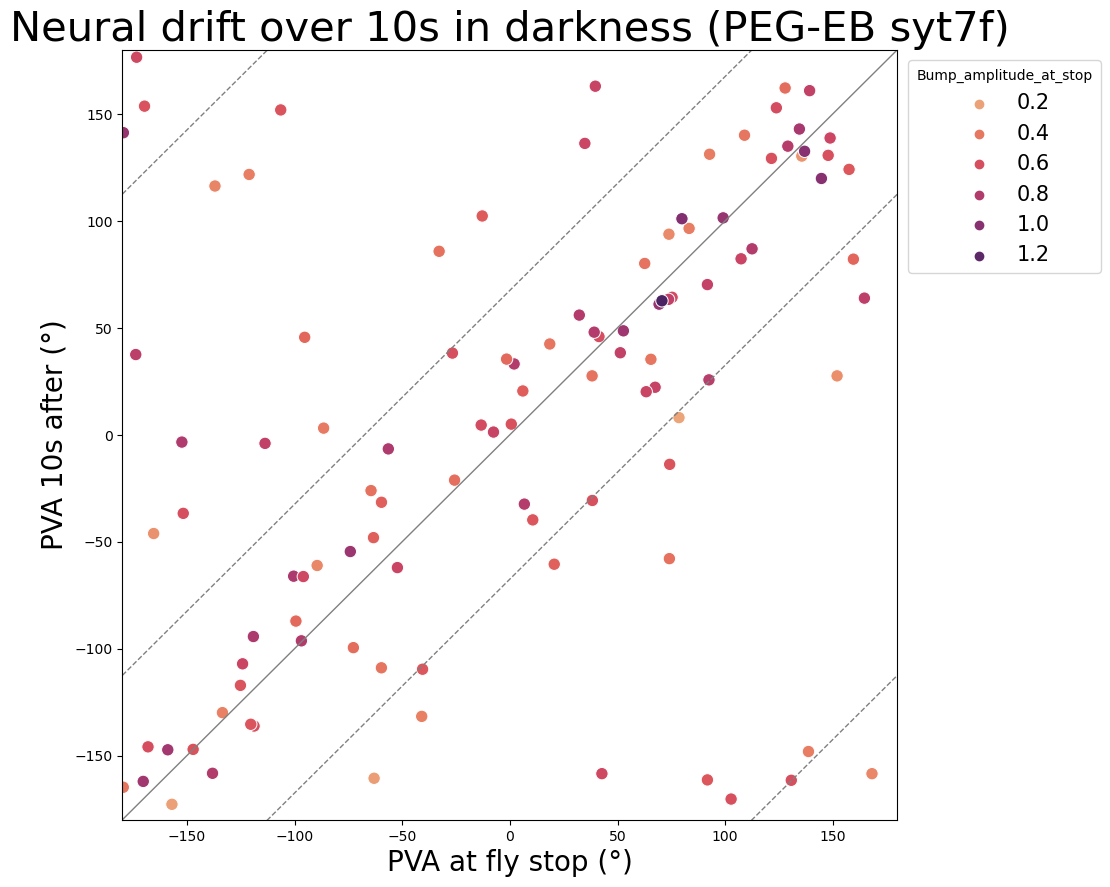

In [46]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_10s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 10s in darkness (PEG-EB syt7f)', fontsize =30)
plt.ylabel('PVA 10s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()
#a.savefig('E-PG_Bump_Angle_10s_after_cl', format ='svg')

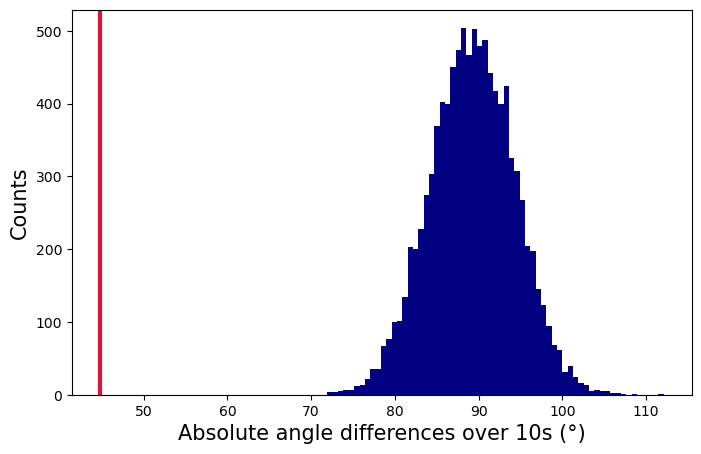

In [47]:
stop_period_start_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)))
stop_period_end_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)
for i in range(len(stop_period_start_10s )):
    stop_period_start_10s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_10s[i] =  persistence_data_pooled['PVA_10s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_10s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_10s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_10s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_10s =  calculate_angle_difference_between_two_time_point(stop_period_start_10s ,stop_period_end_10s)
actual_mean_absolute_angle_diff_10s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_10s))
actual_mean_absolute_angle_diff_10s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto',color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_10s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 10s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()

In [48]:
np.quantile(bootstrap_mean_angle_differences_10000,0.000000000001)

71.94985197829898

In [49]:
len(long_trial_index)

107

In [50]:
actual_mean_absolute_angle_diff_10s    

44.79147607768214

In [52]:
#from scipy.stats import ranksums
#ranksums(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [167]:
stats.mannwhitneyu(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff), alternative = 'two-sided')

MannwhitneyuResult(statistic=3465.0, pvalue=0.0296191376401522)

In [173]:
np.savetxt('angle_difference_cl_10s.csv', np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [56]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [57]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [58]:
persistence_data_pooled

FlyTrial        Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly020-004  R60D05>GCaMP7f        cl          8.63612       152.779284  \
1    TQfly020-004  R60D05>GCaMP7f        cl          4.31806       -86.439229   
2    TQfly020-004  R60D05>GCaMP7f        cl         37.35624       -85.523872   
3    TQfly020-004  R60D05>GCaMP7f        cl          5.92478        -1.320021   
4    TQfly020-004  R60D05>GCaMP7f        cl          6.92898       104.161500   
..            ...             ...       ...              ...              ...   
144  TQfly006-004  R60D05>GCaMP7f        cl         20.02497       -42.736785   
145  TQfly006-004  R60D05>GCaMP7f        cl         23.74218       138.222288   
146  TQfly006-004  R60D05>GCaMP7f        cl         15.58830      -142.700005   
147  TQfly006-004  R60D05>GCaMP7f        cl         13.07019      -131.178308   
148  TQfly006-004  R60D05>GCaMP7f        cl         88.01394       149.353316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0        129.954677                156.596466                 16.232703  \
1        -68.797495                -74.962955                -69.155067   
2        -64.215069                -65.600353                -34.962486   
3         32.400089                 40.185377                 39.926749   
4        103.727001                105.218979                104.758681   
..              ...                       ...                       ...   
144      -77.586427                -48.538572                -72.358036   
145     -163.702983               -173.821122               -166.495025   
146     -149.362476               -157.569945                -99.942970   
147     -150.006876               -143.112831                177.899859   
148     -118.466666                 55.608811                 50.969139   

     PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_at_restart   
0      -157.673166             113.858629  ...                   0.120168  \
1       -55.013859             -65.503918  ...                   0.494114   
2       -24.163843             -84.568892  ...                   0.124029   
3        43.955119              66.408276  ...                   0.502485   
4        96.081117              99.294985  ...                   0.958967   
..             ...                    ...  ...                        ...   
144    -132.141746            -100.250723  ...                   0.254206   
145    -165.264493             142.279049  ...                   0.238209   
146    -120.791635             162.518259  ...                   0.301008   
147    -127.937979            -165.489649  ...                   0.240625   
148      19.296692              47.018918  ...                   0.105966   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.118655                             0.180550  \
1                               0.514409                             0.639346   
2                               0.107755                             0.185554   
3                               0.438824                             0.672808   
4                               1.017992                             1.064665   
..                                   ...                                  ...   
144                             0.227604                             0.197644   
145                             0.248334                             0.241640   
146                             0.278209                             0.304520   
147                             0.240952                             0.214188   
148                             0.220290                             0.319481   

     bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                    0.139993                          0.102664  \
1                    0.587214                          0.447535   
2                    0.201707       

In [59]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_cl.csv',encoding = 'utf-8', index=False)